<a href="https://colab.research.google.com/github/jgorsc5200/Horion/blob/master/Copy_of_Game_pitch_viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instructions**

To use this script, first you will have to click the play button below next to the text "18 cells hidden". The code should be minimized by default, but if it's not (if you can see the code) click the arrow next to "Instructions" to hide it, although you are welcome to read the code for the script.

Once you've clicked the play button, the script will load and you should be ready to go! Then you can scroll down to the sections for viewing pitches from a single game, day, or range of days.

In [ ]:
# Import necessary libraries

import requests
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import plotly.graph_objects as go
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.path import Path
import math
from google.colab import auth
import gspread
from google.auth import default
import seaborn as sns
import skimage.measure as measure
import scipy.ndimage

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Program constants

RAD = 1.45 / 12
BOX_EDGE = 17/24
EDGE = BOX_EDGE + RAD
SZ_TOP = 3.40
SZ_BOT = 1.60

In [ ]:
# Weighted average weights by year
STRIKE_WEIGHTS = {
    2008: 1 / 2.213484,
    2009: 1 / 2.282192,
    2010: 1 / 2.126098,
    2011: 1 / 2.074586,
    2012: 1 / 1.993123,
    2013: 1 / 1.794175,
    2014: 1 / 1.711986,
    2015: 1 / 1.646174,
    2016: 1 / 1.570940,
    2017: 1 / 1.529856,
    2018: 1 / 1.377244,
    2019: 1 / 1.331788,
    2020: 1 / 1.324945,
    2021: 1 / 1.328940,
    2022: 1 / 1.229299,
    2023: 1 / 1.184396,
    2024: 1 / 1.184396, # same as 2023
}

BALL_WEIGHTS = {
    2008: 1 / 2.056458,
    2009: 1 / 1.884769,
    2010: 1 / 1.640241,
    2011: 1 / 1.673282,
    2012: 1 / 1.620234,
    2013: 1 / 1.540588,
    2014: 1 / 1.498970,
    2015: 1 / 1.477229,
    2016: 1 / 1.484509,
    2017: 1 / 1.396328,
    2018: 1 / 1.317927,
    2019: 1 / 1.286606,
    2020: 1 / 1.218047,
    2021: 1 / 1.204478,
    2022: 1 / 1.193614,
    2023: 1 / 1.216463,
    2024: 1 / 1.216463, # same as 2023
}

In [ ]:
# run expectancy delta for umpire runs created from umpscorecards
RED_TABLE = pd.DataFrame({"outs": [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2],
                          "runner_1b": [True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False],
                          "runner_2b": [True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False,True,True,False,False],
                          "runner_3b": [True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,False,False,False,False],
                          "balls": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                          "strikes": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],
                          "run_exp_delta": [0.1,0.15,0.07,0.25,0.13,0.14,0.15,0.1,0.24,0.16,0.13,0.13,0.12,0.08,0.08,0.06,0.29,0.09,0.12,0.09,0.08,0.06,0.07,0.03,0.02,0.26,0.05,0.36,0.14,0.13,0.12,0.09,0.31,0.24,0.14,0.16,0.16,0.08,0.1,0.07,0.26,0.22,0.12,0.1,0.13,0.1,0.08,0.04,0.71,0.36,0.42,0.48,0.38,0.27,0.27,0.17,0.55,0.59,0.62,0.45,0.37,0.26,0.22,0.12,0.45,0.41,0.37,0.25,0.33,0.22,0.17,0.07,0.09,0.42,0.28,0.01,0.23,0.19,0.22,0.13,0.3,0.14,0.11,0.21,0.12,0.12,0.1,0.08,0.43,0.05,0.1,0.1,0.11,0.08,0.07,0.04,0.04,0.29,0.19,0.01,0.17,0.25,0.16,0.11,0.3,0.24,0.1,0.22,0.2,0.12,0.14,0.08,0.41,0.14,0.17,0.15,0.13,0.09,0.07,0.05,0.64,0.41,0.44,0.35,0.51,0.39,0.33,0.2,0.76,0.68,0.65,0.5,0.43,0.35,0.27,0.15,0.65,0.42,0.4,0.3,0.39,0.25,0.19,0.09,0.56,0.12,0.28,0.02,0.5,0.2,0.3,0.2,0.56,0.12,0.02,0.33,0.15,0.21,0.19,0.11,0.49,0.29,0.1,0.05,0.21,0.19,0.12,0.05,0.4,0.28,0.45,0.36,0.31,0.26,0.28,0.21,0.38,0.16,0.2,0.33,0.32,0.19,0.16,0.12,0.43,0.26,0.26,0.11,0.19,0.13,0.13,0.06,0.99,0.28,0.65,0.5,0.67,0.48,0.53,0.29,0.79,0.76,0.74,0.56,0.6,0.38,0.4,0.22,1.04,0.56,0.46,0.39,0.5,0.3,0.26,0.13,0.74,0.22,0.19,0.06,0.51,0.13,0.31,0.22,0.62,0.09,0.15,0.01,0.32,0.08,0.29,0.16,0.66,0.06,0.09,0.09,0.16,0.05,0.11,0.07,0.79,0.63,0.43,0.27,0.66,0.3,0.4,0.33,0.97,0.17,0.26,0.28,0.47,0.24,0.33,0.22,0.7,0.18,0.28,0.11,0.24,0.14,0.17,0.1,1.78,0.92,1.08,0.77,1.34,0.78,0.93,0.62,1.77,0.93,1,0.84,1.07,0.62,0.72,0.43,1.74,0.74,0.64,0.5,0.74,0.44,0.44,0.22]})

In [ ]:
def calc_run_exp_delta(pitch):
    if pitch["correct_call"]:
        return 0.0
    else:
        lookup = RED_TABLE[(RED_TABLE['outs'] == pitch['outs']) &
                           (RED_TABLE['runner_1b'] == pitch['runner_1b']) &
                           (RED_TABLE['runner_2b'] == pitch['runner_2b']) &
                           (RED_TABLE['runner_3b'] == pitch['runner_3b']) &
                           (RED_TABLE['balls'] == pitch['balls']) &
                           (RED_TABLE['strikes'] == pitch['strikes'])]['run_exp_delta'].values[0]
        return -lookup if pitch["actual_call"] else lookup

In [ ]:
# 2D Zone utilities

def get_miss_distance(pitch):
    px = pitch['px']
    pz = pitch['pz']
    sz_top = pitch['sz_top']
    sz_bot = pitch['sz_bot']

    # if the call is correct, then the miss distance is 0
    if pitch["correct_call"]:
        return 0.0
    if pitch["actual_call"]:
        # get horizontal miss distance
        if -EDGE <= px <= EDGE:   # horizontally, in the zone
            miss_horiz = 0.0
        else:
            miss_horiz = abs(px) - EDGE
        # get vertical miss distance
        if sz_bot - RAD <= pz <= sz_top + RAD:
            miss_vert = 0.0
        elif pz > sz_top + RAD:
            miss_vert = pz - (sz_top + RAD)
        elif pz < sz_bot - RAD:
            miss_vert =  -pz + (sz_bot - RAD)
        else:
            miss_vert = np.NaN

        return np.linalg.norm((miss_horiz, miss_vert)) * 12
    else:
        miss_horiz = min(abs(px - EDGE), abs(px + EDGE))
        miss_vert = min(abs(pz - (sz_bot - RAD)), abs(pz - (sz_top + RAD)))

        return min(miss_horiz, miss_vert) * 12

In [ ]:
# 3D Zone utilities

def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))

# < 0: inside
# = 0: ?
# > 0: outside
def intersects(rleft, rright, rbot, rtop, cx, cz, rad):
    if rleft - rad <= cx <= rright + rad and rbot - rad <= cz <= rtop + rad:
    # center is completely within the bounds
        miss_horiz = min(abs(cx - (rleft - rad)), abs(cx - (rright + rad)))
        miss_vert = min(abs(cz - (rbot - rad)), abs(cz - (rtop + rad)))

        return -min(miss_horiz, miss_vert)

    closest_x = clamp(cx, rleft, rright)
    closest_z = clamp(cz, rbot, rtop)

    distance_x = cx - closest_x
    distance_z = cz - closest_z

    distance = math.sqrt(distance_x ** 2 + distance_z ** 2)

    return distance - rad

def clamp_np(n, smallest, largest):
    return np.maximum(smallest, np.minimum(n, largest))

def intersects_np(rleft, rright, rbot, rtop, cx, cz):
    closest_x = clamp_np(cx, rleft, rright)
    closest_z = clamp_np(cz, rbot, rtop)

    distance_x = cx - closest_x
    distance_z = cz - closest_z

    distance = np.sqrt(distance_x ** 2 + distance_z ** 2)

    result = np.where(distance > 0, 0, 1)

    return result

def is_in_zone(point, sz_bot, sz_top):
    px, py, pz = point
    py = np.asarray(py)
    mask = (py > 17/12) | (py < 0)
    result = np.zeros_like(py)
    if np.any(mask):
        result[mask] = 0
    mask = (17/24 <= py) & (py <= 17/12)
    if np.any(mask):
        val = intersects_np(-17/24, 17/24, sz_bot, sz_top, px[mask], pz[mask])
        result[mask] = val
    mask = (0 <= py) & (py < 17/24)
    if np.any(mask):
        val = intersects_np(-py[mask], py[mask], sz_bot, sz_top, px[mask], pz[mask])
        result[mask] = val
    return result

def polynomial(pos, vel, acc):
    return (lambda t: [acc[0]/2 * t**2 + vel[0] * t + pos[0],
                       acc[1]/2 * t**2 + vel[1] * t + pos[1],
                       acc[2]/2 * t**2 + vel[2] * t + pos[2]],
            lambda t: [acc[0] * t + vel[0],
                       acc[1] * t + vel[1],
                       acc[2] * t + vel[2]],
            (-vel[1] - math.sqrt((vel[1] ** 2) - 2 * acc[1] * (pos[1] - (17/12)))) / acc[1],
            (-vel[1] - math.sqrt((vel[1] ** 2) - 2 * acc[1] * pos[1])) / acc[1])

N = 100

def surface(pitch):
    pos = [pitch['x0'], pitch['y0'], pitch['z0']]
    vel = [pitch['vx0'], pitch['vy0'], pitch['vz0']]
    acc = [pitch['ax'], pitch['ay'], pitch['az']]

    sz_top = pitch['sz_top']
    sz_bot = pitch['sz_bot']

    p, d, t1, t2 = polynomial(pos, vel, acc)

    def surface2(t1, t2, fac=1):
        N_ = int(N / fac)

        ts = np.linspace(t1, t2, num = N_)
        X, Y, Z = p(ts)
        C = np.array(p(ts)).transpose()

        X_vel, Y_vel, Z_vel = d(ts)
        V = []
        W = []
        for i in range(N_):
            v = np.array([Y_vel[i], -X_vel[i], 0])
            v = v / np.linalg.norm(v)
            V.append(v)
            a = np.array([X_vel[i], Y_vel[i], Z_vel[i]])
            w = np.cross(a, v)
            w = w / np.linalg.norm(w)
            W.append(w)
        V = np.array(V)
        W = np.array(W)

        X.shape = (N_, 1)
        Z.shape = (N_, 1)
        X = np.tile(X, (1, N_))
        Z = np.tile(Z, (1, N_))

        theta = np.linspace(0, 2*np.pi, num=N_)
        theta_grid, _= np.meshgrid(theta, Y)

        Y.shape = (N_, 1)
        Y = np.tile(Y, (1, N_))

        y_grid = Y + RAD * np.cos(theta_grid) * V[:,1] + RAD * np.sin(theta_grid) * W[:,1]
        x_grid = X + RAD * np.cos(theta_grid) * V[:,0] + RAD * np.sin(theta_grid) * W[:,0]
        z_grid = Z + RAD * np.cos(theta_grid) * V[:,2] + RAD * np.sin(theta_grid) * W[:,2]

        path_name = "Ball path"
        return go.Surface(x=x_grid, y = y_grid, z = z_grid,
                          surfacecolor=is_in_zone((x_grid, y_grid, z_grid),
                                                      sz_bot, sz_top),
                          colorscale=[[0, 'rgb(0,0,255)'], [0.5, 'rgb(0,0,255)'], [1, 'rgb(255,255,0)']],
                          showscale=False, name=path_name)

    surface_zone = surface2(t1-0.0002, t2+0.0002)
    surface_after = surface2(t2+0.0002, t2+0.03, fac=4)
    surface_before = surface2(t1-0.03, t1-0.0002, fac=3)

    # surface_all = surface2(t1-0.02, t2+0.02)

    sz_name = "Strike zone"

    return [
            surface_zone,
            surface_before,
            surface_after,
            # surface_all,
            go.Mesh3d(x=[-17/24, -17/24, 0.0, 17/24, 17/24],
                      y=[ 17/12,  17/24, 0.0, 17/24, 17/12],
                      z=[sz_bot]*5,
                      opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[-17/24, -17/24, 0.0, 17/24, 17/24],
                      y=[ 17/12,  17/24, 0.0, 17/24, 17/12],
                      z=[sz_top]*5,
                      opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[-17/24, 17/24, 17/24, -17/24],
                      y=[17/12]*4,
                      z=[sz_bot, sz_bot, sz_top, sz_top],
                      delaunayaxis='y', opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[17/24]*4,
                      y=[17/12,17/24,17/24,17/12],
                      z=[sz_bot, sz_bot, sz_top, sz_top],
                      delaunayaxis='x', opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[-17/24]*4,
                      y=[17/12,17/24,17/24,17/12],
                      z=[sz_bot, sz_bot, sz_top, sz_top],
                      delaunayaxis='x', opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[0, 0, -17/24, -17/24],
                      y=[0, 0, 17/24, 17/24],
                      z=[sz_bot, sz_top, sz_top, sz_bot],
                      delaunayaxis='x', opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name),
            go.Mesh3d(x=[0, 0, 17/24, 17/24],
                      y=[0, 0, 17/24, 17/24],
                      z=[sz_bot, sz_top, sz_top, sz_bot],
                      delaunayaxis='x', opacity = 0.5, flatshading=True, color='gray',
                      name=sz_name)]

def pitch_in_zone_3d(pitch):
    pos = [pitch['x0'], pitch['y0'], pitch['z0']]
    vel = [pitch['vx0'], pitch['vy0'], pitch['vz0']]
    acc = [pitch['ax'], pitch['ay'], pitch['az']]

    sz_top = pitch['sz_top']
    sz_bot = pitch['sz_bot']

    p, d, t1, t2 = polynomial(pos, vel, acc)

    N_ = 50

    ts = np.linspace(t1, t2, num = N_)
    X, Y, Z = p(ts)
    C = np.array(p(ts)).transpose()

    X_vel, Y_vel, Z_vel = d(ts)
    V = []
    W = []
    for i in range(N_):
        v = np.array([Y_vel[i], -X_vel[i], 0])
        v = v / np.linalg.norm(v)
        V.append(v)
        a = np.array([X_vel[i], Y_vel[i], Z_vel[i]])
        w = np.cross(a, v)
        w = w / np.linalg.norm(w)
        W.append(w)
    V = np.array(V)
    W = np.array(W)

    theta = np.linspace(0, 2*np.pi, num=25)

    coords = []
    for i in range(C.shape[0]):
        c = C[i,:]
        v = V[i,:]
        w = W[i,:]
        for t in theta:
            p = np.array([c[0] + RAD * np.cos(t) * v[0] + RAD * np.sin(t) * w[0],
                          c[1] + RAD * np.cos(t) * v[1] + RAD * np.sin(t) * w[1],
                          c[2] + RAD * np.cos(t) * v[2] + RAD * np.sin(t) * w[2]])
            coords.append(p)
    coords = np.array(coords)

    min_ball = 100000
    min_strike = 0
    for point in coords:
        px = point[0]
        py = point[1]
        pz = point[2]

        dist = 0
        if 17/24 <= py <= 17/12:
            dist = intersects(-17/24, 17/24, sz_bot, sz_top, px, pz, 0)
        if 0 <= py < 17/24:
            dist = intersects(-py, py, sz_bot, sz_top, px, pz, 0)

        if dist < 0: # strike
            min_strike = min(min_strike, dist)
        elif dist > 0: # ball
            min_ball = min(min_ball, dist)

    return min_strike if min_strike < 0 else min_ball

In [ ]:
# 3D Plot

def plot_pitches_3d(df):
    surfaces = []
    for n, p in df.iterrows():
        # print(n)
        s = surface(p)
        # print(len(s))
        surfaces.append(s)


    def flatten(matrix):
        return [item for row in matrix for item in row]

    surfaces3 = flatten(surfaces)

    # Create dropdown options for groups
    dropdown_options = []
    for i, group in enumerate(surfaces):
        visibility = [False] * len(surfaces3)
        for surface2 in group:
            visibility[surfaces3.index(surface2)] = True
        dropdown_options.append({'label': f'Miss #{i+1}',
                                 'method': 'update', 'args': [{'visible': visibility}]})

    # Create initial layout with the first surface visible
    layout = go.Layout(
        scene=dict(
            xaxis = dict(nticks=0, range=[-3, 3], visible=False, showgrid=False),
            yaxis = dict(nticks=0, range=[-2.5, 5], visible=False, showgrid=False),
            zaxis = dict(nticks=1, range=[0,6], showticklabels=False),
            zaxis_title = "",
            aspectmode='manual',
            aspectratio=dict(x=6,y=7.5,z=6)
        ),
        updatemenus=[
            dict(
                buttons=dropdown_options,
                direction='down',
                showactive=True,
                x=0.0,
                xanchor='left',
                y=1.1,
                yanchor='top'
            )
        ],
        margin = dict(b = 10, l = 10, r = 10, t = 50),
        width=800,
        height=500
    )

    # Combine data and layout into a figure
    fig = go.Figure(data=surfaces3, layout=layout)
    fig.update_traces(visible='legendonly')

    # Show the figure
    fig.show()


def plot_3d(px, pz, sz_top, sz_bot):
    ax = plt.figure().add_subplot(projection='3d')


    # Make data
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = RAD * np.outer(np.cos(u), np.sin(v)) + px
    y = RAD * np.outer(np.sin(u), np.sin(v))
    z = RAD * np.outer(np.ones(np.size(u)), np.cos(v)) + pz

    # Plot the surface
    ax.plot_surface(x, y, z)

    # Plot a sin curve using the x and y axes.
    x = [-17/24, 17/24, 17/24, -17/24, -17/24]
    y = [0, 0, 0, 0, 0]
    z = [sz_bot, sz_bot, sz_top, sz_top, sz_bot]
    ax.plot(x, y, z, color='black')

    x = [-17/24, -17/24, -17/24, -17/24]
    y = [0, -8.5/12, -8.5/12, 0]
    z = [sz_bot, sz_bot, sz_top, sz_top]
    ax.plot(x, y, z, color='black')

    x = [17/24, 17/24, 17/24, 17/24]
    ax.plot(x, y, z, color='black')

    x = [-17/24, 0, 0, -17/24]
    y = [-8.5/12, -17/12, -17/12, -8.5/12]
    z = [sz_bot, sz_bot, sz_top, sz_top]
    ax.plot(x, y, z, color='black')

    x = [17/24, 0, 0, 17/24]
    ax.plot(x, y, z, color='black')

    # Make legend, set axes limits and labels
    ax.set_xlim(-2, 2)
    ax.set_ylim(1, -2)
    ax.set_zlim(0, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    ax.view_init(elev=10., azim=-75, roll=0)
    ax.set_aspect('equal', adjustable='box')


In [ ]:
# Data utilities
database = {}

def download_game_mlb(game_pk):
    # download game data through a request
    print("Downloading data through Gamefinder...", end="")
    r = requests.get("https://baseballsavant.mlb.com/gf", params={"game_pk": game_pk})
    print("Done!")
    gamefinder = json.loads(r.content)

    # get extra statsapi information
    print("Downloading data through StatsAPI...", end="")
    r = requests.get(f"https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live")
    print("Done!")
    statsapi = json.loads(r.content)

    return {"gamefinder": gamefinder, "statsapi": statsapi}

def load_data_file(filename):
    with open(filename) as file:
        data = json.load(file)
        print("Detected", len(data), "games")
        database.update(data)

def get_game_data(game_pk, force_update=False):
    if str(game_pk) in database and not force_update:
        return database[str(game_pk)]
    else:
        data = download_game_mlb(game_pk)
        database[str(game_pk)] = data
        return data

In [ ]:
# Game pitch utilities

def get_pitches_play(play):
    df = pd.DataFrame(play['playEvents'])
    if 'isPitch' in df:
        try:
            df['event_description'] = play['result']['event']
        except KeyError:
            df['event_description'] = pd.NA
        try:
            df['event_type'] = play['result']['eventType']
        except KeyError:
            df['event_type'] = pd.NA

        # check for ABS challenge
        df[['has_challenge', 'review_team', 'challenge_result']] = df.apply(get_challenge_status, axis = 1, result_type='expand')

        # fix for stolen bases?
        for row, event in df.iterrows():
            if not event['isPitch'] and event['details']['hasReview'] and event['reviewDetails']['reviewType'] == 'MJ':
                df.loc[int(row) - 1, 'has_challenge'] = True
                df.loc[int(row) - 1, 'review_team'] = event['reviewDetails']['challengeTeamId']
                df.loc[int(row) - 1, 'challenge_result'] = event['reviewDetails']['isOverturned']

        # last pitch challenge
        if 'hasReview' in play['about'] and play['about']['hasReview'] and play['reviewDetails']['reviewType'] == 'MJ':
            df.loc[df.index[-1], 'has_challenge'] = True
            df.loc[df.index[-1], 'review_team'] = play['reviewDetails']['challengeTeamId']
            df.loc[df.index[-1], 'challenge_result'] = play['reviewDetails']['isOverturned']

        df = df[df['isPitch'] == True]

        return df
    else:
        return pd.DataFrame()

def get_challenge_status(pitch):
    if pitch['details']['hasReview'] and 'challengeTeamId' in pitch['reviewDetails']:
        return True, pitch['reviewDetails']['challengeTeamId'], pitch['reviewDetails']['isOverturned']
    else:
        return False, pd.NA, pd.NA

def get_game_pitches(game_pk):
    data = get_game_data(game_pk)

    # game pitch data from gamefinder
    home_pitches = pd.DataFrame(data['gamefinder']['team_home'])
    home_pitches["half_inning"] = "top"

    try:
        away_pitches = pd.DataFrame(data['gamefinder']['team_away'])
        away_pitches["half_inning"] = "bottom"
    except KeyError:
        away_pitches = pd.DataFrame()

    game_pitches = pd.concat([away_pitches, home_pitches], ignore_index = True)
    game_pitches.drop(columns = ["outs"], inplace=True)

    # place extra game information for each pitch
    game_pitches["away_team"]   = data['gamefinder']["scoreboard"]["teams"]["away"]["name"]
    game_pitches["away_abbrev"] = data['gamefinder']["scoreboard"]["teams"]["away"]["abbreviation"]
    game_pitches["home_team"]   = data['gamefinder']["scoreboard"]["teams"]["home"]["name"]
    game_pitches["home_abbrev"] = data['gamefinder']["scoreboard"]["teams"]["home"]["abbreviation"]
    game_pitches["date"]        = data['gamefinder']["scoreboard"]["datetime"]["officialDate"]
    game_pitches["day_night"]   = data['gamefinder']["scoreboard"]["datetime"]["dayNight"]

    extra = pd.concat([get_pitches_play(play) for play in data['statsapi']['liveData']['plays']['allPlays']], axis=0, ignore_index = True)
    extra = pd.concat([extra.drop(['count'], axis=1), extra['count'].apply(pd.Series)], axis=1)
    extra = pd.concat([extra.drop(['details'], axis=1), extra['details'].apply(pd.Series)], axis=1)
    extra = pd.concat([extra.drop(['pitchData'], axis=1), extra['pitchData'].apply(pd.Series)], axis=1)
    extra = pd.concat([extra.drop(['breaks'], axis=1), extra['breaks'].apply(pd.Series)], axis=1)
    try:
        extra['runner_going'] = extra['runnerGoing'].fillna(False)
    except KeyError:
        extra['runner_going'] = False
    extra.rename({"playId": "play_id"}, inplace=True, axis=1)
    if 'spinDirection' not in extra:
        extra['spinDirection'] = np.NaN
    if 'breakLength' not in extra:
        extra['breakLength'] = np.NaN
    if 'breakAngle' not in extra:
        extra['breakAngle'] = np.NaN
    if 'breakVertical' not in extra:
        extra['breakVertical'] = np.NaN
    if 'breakHorizontal' not in extra:
        extra['breakHorizontal'] = np.NaN
    if 'strikeZoneWidth' not in extra:
        extra['strikeZoneWidth'] = 17.0
    if 'strikeZoneDepth' not in extra:
        extra['strikeZoneDepth'] = 17.0
    # check for ABS challenge
    extra['review_team'] = extra['review_team'] == data['statsapi']['gameData']['teams']['home']['id']
    extra = extra[['play_id', 'outs', 'runner_going', 'spinDirection', 'event_type', 'event_description',
                   'breakVertical', 'breakHorizontal', 'breakLength', 'breakAngle',
                   'strikeZoneWidth', 'strikeZoneDepth',
                   'has_challenge', 'review_team', 'challenge_result']]
    extra.rename({"playId": "play_id"}, inplace=True, axis=1)


    # this is the main game dataframe
    game_pitches = pd.merge(game_pitches, extra, how="left", on=["play_id"])
    game_pitches.set_index("play_id", inplace=True)
    game_pitches = game_pitches.sort_values("game_total_pitches")

    # search for umpire name in the list of officials
    umpire = next((umpire for umpire in data['gamefinder']['boxscore']['officials'] if umpire["officialType"] == "Home Plate"), None)["official"]["fullName"]
    game_pitches["plate_umpire"] = umpire

    # rename columns
    game_pitches.rename({'stand': 'batter_side',
                        'p_throws': 'pitcher_hand',
                        'pitch_type': 'pitch_code',
                        'pitch_name': 'pitch_description',
                        'description': 'result_description',
                        'zone': 'gameday_zone',
                        'pfxX': 'pfx_x', 'pfxZ': 'pfx_z',
                        'breakHorizontal': 'break_x', 'breakVertical': 'break_z',
                        'breakLength': 'break_length', 'breakAngle': 'break_angle',
                        "spinDirection": "spin_axis",
                        'runnerOn1B': 'runner_1b',
                        'runnerOn2B': 'runner_2b',
                        'runnerOn3B': 'runner_3b',
                        'strikeZoneWidth': 'sz_width',
                        'strikeZoneDepth': 'sz_depth'}, axis=1,inplace=True)

    try:
        game_pitches["runner_1b"].fillna(False, inplace=True)
    except KeyError:
        game_pitches["runner_1b"] = False
    try:
        game_pitches["runner_2b"].fillna(False, inplace=True)
    except KeyError:
        game_pitches["runner_2b"] = False
    try:
        game_pitches["runner_3b"].fillna(False, inplace=True)
    except KeyError:
        game_pitches["runner_3b"] = False

    # check default strike zone information
    game_pitches["sz_top_def"] = game_pitches["batter"].apply(lambda id: data["statsapi"]["gameData"]["players"][f"ID{id}"]["strikeZoneTop"])
    game_pitches["sz_bot_def"] = game_pitches["batter"].apply(lambda id: data["statsapi"]["gameData"]["players"][f"ID{id}"]["strikeZoneBottom"])

    # reorder columns and drop the columns that we don't want
    game_pitches = game_pitches[['game_pk', 'date', 'day_night',
                            'away_team', 'away_abbrev', 'home_team', 'home_abbrev',
                            'game_total_pitches',
                            'inning', 'half_inning', 'outs',
                            'runner_1b', 'runner_2b', 'runner_3b', 'runner_going',
                            'batter_name', 'batter_side', 'pitcher_name', 'pitcher_hand',
                            'pitch_number',
                            'balls', 'strikes',
                            'result_code', 'result_description',
                            'px', 'pz', 'sz_top', 'sz_bot', 'sz_width', 'sz_depth',
                            'gameday_zone',
                            'pitch_code', 'pitch_description',
                            'start_speed', 'end_speed',
                            'x0', 'y0', 'z0',
                            'vx0', 'vy0', 'vz0',
                            'ax', 'ay', 'az',
                            'pfx_x', 'pfx_z',
                            # 'spin_rate', 'spin_axis',
                            'break_x', 'break_z',
                            'break_length', 'break_angle',
                            'event_type', 'event_description',
                            'plate_umpire',
                            'has_challenge', 'review_team', 'challenge_result']]

    return game_pitches

In [ ]:
def expected_strike(zone):
    return int(zone) < 10

def expected_strike_abs(pitch):
    time = (-pitch['vy0'] - math.sqrt((pitch['vy0'] ** 2) - 2 * pitch['ay'] * (pitch['y0'] - (pitch['sz_depth'] / 12)))) / pitch['ay']
    x    = pitch['ax'] / 2 * (time ** 2) + pitch['vx0'] * time + pitch['x0']
    z    = pitch['az'] / 2 * (time ** 2) + pitch['vz0'] * time + pitch['z0']

    theta = np.linspace(0, 2*np.pi, num=60)

    coords = []
    for t in theta:
        p = np.array([x + RAD * np.cos(t),
                      z + RAD * np.sin(t)])
        coords.append(p)
    coords = np.array(coords)

    min_ball = 100000
    min_strike = 0
    for point in coords:
        px = point[0]
        pz = point[1]

        dist = intersects(-pitch['sz_width']/24, pitch['sz_width']/24, pitch['sz_bot'], pitch['sz_top'], px, pz, 0)

        if dist < 0: # strike
            min_strike = min(min_strike, dist)
        elif dist > 0: # ball
            min_ball = min(min_ball, dist)

    return min_strike if min_strike < 0 else min_ball

def actual_strike(result_code):
    return result_code == "C"

def calculate_credit(pitch):
    strike_pct = pitch['ml_pred']
    is_strike = pitch['expected_call']
    is_correct_call = pitch['correct_call']

    if is_correct_call:
        # correct, add points
        if is_strike:
            # earn points to number of umpires who would not get that call
            return 1 - strike_pct
        else:
            return strike_pct
    else:
        # correct, subtract points
        if is_strike:
            return -strike_pct
        else:
            return -(1 - strike_pct)

def max_credit(pitch):
    strike_pct = pitch['ml_pred']
    is_strike = pitch['expected_call']

    if is_strike:
        return 1 - strike_pct
    else:
        return strike_pct

def machine_learning_predict(pitches, model):
    pitches_predict = pitches[['x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'batter_side', 'pitcher_hand', 'balls', 'strikes', 'outs']]
    pitches_predict['batter_side'] = pitches_predict['batter_side'].apply(lambda x: x == 'R')
    pitches_predict['pitcher_hand'] = pitches_predict['pitcher_hand'].apply(lambda x: x == 'R')

    pitches_predict['time'] = pitches_predict.apply(lambda df: (-df['vy0'] - math.sqrt((df['vy0'] ** 2) - 2 * df['ay'] * (df['y0'] - (17/12)))) / df['ay'], axis = 1)

    pitches_predict['x'] = pitches_predict.apply(lambda df: df['ax'] / 2 * (df['time'] ** 2) + df['vx0'] * df['time'] + df['x0'], axis = 1)
    pitches_predict['y'] = pitches_predict.apply(lambda df: df['ay'] / 2 * (df['time'] ** 2) + df['vy0'] * df['time'] + df['y0'], axis = 1)
    pitches_predict['z'] = pitches_predict.apply(lambda df: df['az'] / 2 * (df['time'] ** 2) + df['vz0'] * df['time'] + df['z0'], axis = 1)

    pitches_predict['vx'] = pitches_predict.apply(lambda df: df['ax'] * df['time'] + df['vx0'], axis = 1)
    pitches_predict['vy'] = pitches_predict.apply(lambda df: df['ay'] * df['time'] + df['vy0'], axis = 1)
    pitches_predict['vz'] = pitches_predict.apply(lambda df: df['az'] * df['time'] + df['vz0'], axis = 1)

    pitches_predict = pitches_predict[['x', 'y', 'z', 'vx', 'vy', 'vz', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'batter_side', 'balls', 'strikes', 'outs']]
    prediction = model.predict(pitches_predict, batch_size = 1)

    pitches['ml_pred']   = prediction
    pitches['ml_credit'] = pitches.apply(calculate_credit, axis=1)
    pitches['ml_max']    = pitches.apply(max_credit, axis=1)
    pitches['ml_min']    = 1 - pitches['ml_max']

    return pitches

In [ ]:
# Display utilities

def normalized_pz(zone_top=SZ_TOP, zone_bot=SZ_BOT):
    return lambda pitch: (
        pitch['pz'] - pitch['sz_top'] + zone_top
        if pitch['pz'] > pitch['sz_top'] - RAD else
        pitch['pz'] - pitch['sz_bot'] + zone_bot
        if pitch['pz'] < pitch['sz_bot'] + RAD else
        (zone_bot + RAD) + ((zone_top - RAD) - (zone_bot + RAD)) * ((pitch['pz'] - (pitch['sz_bot'] + RAD)) / ((pitch['sz_top'] - RAD) - (pitch['sz_bot'] + RAD)))
    )

def normalized_px(pitch):
    pz = pitch['px']
    side = pitch['batter_side']

    return -pz if side == "L" else pz

def disp_round(val, n):
    return f'%.{n}f' % round(val, n)


In [ ]:
def plot_game(game_pk,
              force_update        = True,
              display             = True,
              save                = True,
              live                = False,
              zone                = "2D",
              plot_each_miss_3d   = False,
              show_correct_calls  = True,
              normalize_handedness= True,
              print_incorrect     = True,
              margin_of_error     = False,
              weighted_accuracy   = False,
              machine_learning    = False,
              umpire_runs_created = False,
              consistency_metrics = False,
              override_inning     = None,
              override_half       = None,
              output_pitches      = False,):
    data = get_game_data(game_pk, force_update)
    game_pitches = get_game_pitches(game_pk)

    # game meta information
    away_team   = data['gamefinder']["scoreboard"]["teams"]["away"]["teamName"]
    away_abbrev = data['gamefinder']["scoreboard"]["teams"]["away"]["abbreviation"]
    away_score  = data['gamefinder']['scoreboard']['linescore']['teams']['away']['runs']
    home_team   = data['gamefinder']["scoreboard"]["teams"]["home"]["teamName"]
    home_abbrev = data['gamefinder']["scoreboard"]["teams"]["home"]["abbreviation"]
    home_score  = data['gamefinder']['scoreboard']['linescore']['teams']['home']['runs']
    date        = data['gamefinder']["scoreboard"]["datetime"]["officialDate"]
    year        = int(date[0:4])
    status      = data['gamefinder']['game_status']
    inning      = game_pitches['inning'].max()
    umpire      = game_pitches['plate_umpire'].mode().iloc[0]

    abs_challenges = "absChallenges" in data['statsapi']['gameData'] and zone in ["ABS", "ABS-FSL"]

    na_values = game_pitches["gameday_zone"].isna().sum()
    if na_values != 0:
        print("There were", na_values, "pitches with incomplete data")
        game_pitches.dropna(subset="gameday_zone", inplace=True)

    # pitch visualization information
    zone_top = game_pitches['sz_top'].mean()
    zone_bot = game_pitches['sz_bot'].mean()

    box_width = game_pitches['sz_width'].mean() / 12
    # if zone == "ABS":
    #     print("This strike zone is", box_width * 12, "inches wide")
    #     print("The position is measured", game_pitches['sz_depth'].mean(), "inches from the back of home plate")

    # if normalize_handedness:
    #     game_pitches["px_norm"] = game_pitches.apply(normalized_px, axis=1)
    # else:
    #     game_pitches["px_norm"] = game_pitches["px"]

    # game_pitches["pz_norm"] = game_pitches.apply(normalized_pz(zone_top, zone_bot), axis=1)

    def display_position(pitch):
        time = (-pitch['vy0'] - math.sqrt((pitch['vy0'] ** 2) - 2 * pitch['ay'] * (pitch['y0'] - (pitch['sz_depth'] / 12)))) / pitch['ay']
        x    = pitch['ax'] / 2 * (time ** 2) + pitch['vx0'] * time + pitch['x0']
        z    = pitch['az'] / 2 * (time ** 2) + pitch['vz0'] * time + pitch['z0']

        return (-x if pitch['batter_side'] == "L" else x), (z - pitch['sz_top'] + zone_top
                if z > pitch['sz_top'] - RAD else
                z - pitch['sz_bot'] + zone_bot
                if z < pitch['sz_bot'] + RAD else
                (zone_bot + RAD) + ((zone_top - RAD) - (zone_bot + RAD)) * ((z - (pitch['sz_bot'] + RAD)) / ((pitch['sz_top'] - RAD) - (pitch['sz_bot'] + RAD))))

    game_pitches[["display_x", "display_z"]] = game_pitches.apply(display_position, axis = 1, result_type='expand')

    game_pitches["default_sz"] = game_pitches["sz_top"].apply(lambda sz: abs(sz - round(sz, 3)) < 0.000001) & game_pitches["sz_bot"].apply(lambda sz: abs(sz - round(sz, 3)) < 0.000001)

    # calculate called pitch data
    taken_pitches = game_pitches[game_pitches['result_code'].isin(["*B", "B", "C", "H", "I", "P"])]
    taken_pitches["hit_by_pitch"] = taken_pitches["result_code"] == "H"

    match zone:
        case "2D":
            taken_pitches['expected_call'] = taken_pitches['gameday_zone'].apply(expected_strike)
            taken_pitches['actual_call']   = taken_pitches['result_code'].apply(actual_strike)
            taken_pitches['correct_call']  = taken_pitches['expected_call'] == taken_pitches['actual_call']
            taken_pitches["miss_distance"] = taken_pitches.apply(get_miss_distance, axis = 1, result_type='expand')
        case "3D":
            taken_pitches['miss_distance'] = taken_pitches.apply(pitch_in_zone_3d, axis = 1) * 12
            taken_pitches['expected_call'] = taken_pitches['miss_distance'] < 0
            taken_pitches['expected_call_2d'] = taken_pitches['gameday_zone'].apply(expected_strike)
            taken_pitches['actual_call']   = taken_pitches['result_code'].apply(actual_strike)
            taken_pitches['correct_call']  = taken_pitches['expected_call'] == taken_pitches['actual_call']
        case "ABS":
            taken_pitches['miss_distance'] = taken_pitches.apply(expected_strike_abs, axis = 1) * 12
            taken_pitches['expected_call'] = taken_pitches['miss_distance'] < 0
            taken_pitches['actual_call']   = taken_pitches['result_code'].apply(actual_strike)
            taken_pitches['correct_call']  = taken_pitches['expected_call'] == taken_pitches['actual_call']
        case "override":
            if override_half == 'top':
                taken_pitches['override_delete'] = ((taken_pitches['inning'] == override_inning) & (taken_pitches['half_inning'] == "bottom")) | (taken_pitches['inning'] > override_inning)
            elif override_half == 'bottom':
                taken_pitches['override_delete'] = taken_pitches['inning'] > override_inning
            else:
                print("Illegal half-inning selected: must be 'top' or 'bottom'")
                return
            taken_pitches = taken_pitches[~taken_pitches['override_delete']]
            taken_pitches['expected_call'] = taken_pitches['gameday_zone'].apply(expected_strike)
            taken_pitches['actual_call']   = taken_pitches['result_code'].apply(actual_strike)
            taken_pitches['correct_call']  = (taken_pitches['inning'] != override_inning) | (taken_pitches['half_inning'] != override_half)
            taken_pitches["miss_distance"] = taken_pitches.apply(get_miss_distance, axis = 1, result_type='expand')
        case _:
            print('Error: Invalid zone type selected. Valid options are "2D", "3D", and "ABS"')
            return

    taken_pitches["correct_ccs"] = (taken_pitches['correct_call']) | (taken_pitches["miss_distance"].abs() <= 1.0)
    taken_pitches["correct_mlb"] = (taken_pitches['correct_call']) | (taken_pitches["miss_distance"].abs() <= 2.0)

    ## MACHINE LEARNING!!
    if machine_learning:
        model = UMPIRE_MODELS[year]
        machine_learning_predict(taken_pitches, model)

    # missed calls
    missed_calls = taken_pitches[taken_pitches['correct_call'] == False]
    missed_calls.reset_index(inplace=True)

    # scorecard data
    total_calls     = len(taken_pitches)

    num_missed      = len(missed_calls)
    num_missed_ccs  = len(missed_calls[missed_calls["correct_ccs"] == False])
    num_missed_mlb  = len(missed_calls[missed_calls["correct_mlb"] == False])

    accuracy        = taken_pitches['correct_call'].mean() * 100
    accuracy_ccs    = taken_pitches['correct_ccs'].mean() * 100
    accuracy_mlb    = taken_pitches['correct_mlb'].mean() * 100

    if margin_of_error:
        missed_calls = missed_calls[missed_calls["miss_distance"] >= 1.0]

    if machine_learning:
        accuracy_exp = taken_pitches['ml_min'].sum() / (taken_pitches['ml_min'].sum() + taken_pitches['ml_max'].sum()) * 100
        umpire_zone  = taken_pitches['ml_credit'].sum()
    else:
        accuracy_exp = float("NaN")
        umpire_zone  = float("NaN")

    # weighted accuracy calculation
    if weighted_accuracy:
        weight_strike   = STRIKE_WEIGHTS[year]
        weight_ball     = BALL_WEIGHTS[year]
        w_accuracy      = (1 - (weight_strike * missed_calls[missed_calls['actual_call'] == True]['miss_distance'].abs().sum()
                                + weight_ball * missed_calls[missed_calls['actual_call'] == False]['miss_distance'].abs().sum())
                                / len(taken_pitches)) * 100
        avg_miss        = missed_calls['miss_distance'].abs().mean()
    else:
        w_accuracy      = float('NaN')

    # pitcher batter favor
    if umpire_runs_created:
        favor = (taken_pitches["actual_call"].mean() - taken_pitches["expected_call"].mean()) / taken_pitches["expected_call"].mean() * 100
    else:
        favor = float('NaN')

    # call types
    called_strikes = taken_pitches[taken_pitches['actual_call'] == True]
    called_balls   = taken_pitches[taken_pitches['actual_call'] == False]
    true_balls     = taken_pitches[taken_pitches['expected_call'] == False]
    true_strikes   = taken_pitches[taken_pitches['expected_call'] == True]

    inc_called_strikes = called_strikes[called_strikes["correct_call"] == False]
    inc_called_balls   = called_balls[called_balls["correct_call"] == False]
    inc_true_strikes   = true_strikes[true_strikes["correct_call"] == False]
    inc_true_balls     = true_balls[true_balls["correct_call"] == False]

    # pitches by count
    pitches_by_count   = [[taken_pitches[(taken_pitches['balls'] == ball) & (taken_pitches['strikes'] == strike)]
                           for strike in range(3)] for ball in range(4)]
    incorrect_by_count = [[missed_calls[(missed_calls['balls'] == ball) & (missed_calls['strikes'] == strike)]
                           for strike in range(3)] for ball in range(4)]

    pitches_balls       = [taken_pitches[taken_pitches['balls'] == ball] for ball in range(4)]
    incorrect_balls     = [missed_calls[(missed_calls['balls'] == ball)] for ball in range(4)]

    pitches_strikes     = [taken_pitches[taken_pitches['strikes'] == strike] for strike in range(3)]
    incorrect_strikes   = [missed_calls[(missed_calls['strikes'] == strike)] for strike in range(3)]

    # umpire runs created
    if umpire_runs_created:
        taken_pitches["run_exp_delta"] = taken_pitches.apply(calc_run_exp_delta, axis = 1)
        umpire_runs                    = taken_pitches['run_exp_delta'].sum()

        inning_top = taken_pitches[taken_pitches["half_inning"] == "top"]
        inning_bot = taken_pitches[taken_pitches["half_inning"] == "bottom"]

        away_umpire_runs = inning_top['run_exp_delta'].sum()
        home_umpire_runs = inning_bot['run_exp_delta'].sum()
        net_umpire_runs  = home_umpire_runs - away_umpire_runs
    else:
        umpire_runs     = float('NaN')
        net_umpire_runs = float('NaN')

    # team favor
    against_home_ball   = missed_calls[(missed_calls['actual_call'] == False) & (missed_calls['half_inning'] == "top")]
    against_home_strike = missed_calls[(missed_calls['actual_call'] == True)  & (missed_calls['half_inning'] == "bottom")]
    against_away_strike = missed_calls[(missed_calls['actual_call'] == True)  & (missed_calls['half_inning'] == "top")]
    against_away_ball   = missed_calls[(missed_calls['actual_call'] == False) & (missed_calls['half_inning'] == "bottom")]
    net_against         = (len(against_home_ball) + len(against_home_strike)) - (len(against_away_ball) + len(against_away_strike))

    expected_favor      = len(taken_pitches[((taken_pitches['expected_call'] == True)  & (taken_pitches['half_inning'] == "top"))
                                            | (taken_pitches['expected_call'] == False) & (taken_pitches['half_inning'] == "bottom")]) / total_calls
    actual_favor        = len(taken_pitches[((taken_pitches['actual_call'] == True)  & (taken_pitches['half_inning'] == "top"))
                                            | (taken_pitches['actual_call'] == False) & (taken_pitches['half_inning'] == "bottom")]) / total_calls
    team_favor          = (actual_favor - expected_favor) / expected_favor * 100

    # convex hull consistency calculation
    if consistency_metrics:
        def closest_point(row):
            x = row['display_x']
            z = (zone_top + zone_bot) / 2
            angle = np.arctan2(row['display_z'] - z, x)
            closest_x = -RAD * np.cos(angle)
            closest_z = -RAD * np.sin(angle)
            return closest_x + row['display_x'], closest_z + row['display_z']

        called_strikes[['closest_x', 'closest_z']] = called_strikes.apply(closest_point, axis=1, result_type='expand')
        points         = np.array(called_strikes[['closest_x', 'closest_z']])
        hull           = ConvexHull(points)
        vertices       = np.append(hull.vertices, hull.vertices[0])
        path           = Path(points[vertices])
        balls          = np.array(called_balls[['display_x', 'display_z']])
        n_inconsistent = 0
        theta = np.linspace(0, 2 * np.pi)
        for [x, z] in balls:
            xs = x + RAD * np.cos(theta)
            zs = z + RAD * np.sin(theta)

            if np.array(list(map(path.contains_point, np.array([xs, zs]).T))).sum() > 0:
                n_inconsistent += 1

        consistency    = (1 - n_inconsistent / len(called_balls)) * 100
    else:
        consistency    = float('NaN')

    # abs challenge system pitches and statistics
    if abs_challenges:
        challenged_pitches = taken_pitches[taken_pitches["has_challenge"] == True]

        away_success = data['statsapi']['gameData']['absChallenges']['away']['usedSuccessful']
        away_failed  = data['statsapi']['gameData']['absChallenges']['away']['usedFailed']

        home_success = data['statsapi']['gameData']['absChallenges']['home']['usedSuccessful']
        home_failed  = data['statsapi']['gameData']['absChallenges']['home']['usedFailed']

    # plot the pitches
    if display:
        fig, ax = plt.subplots()

        plt.xlim([-2, 2])
        plt.ylim([0, 5])
        ax.set_aspect('equal', adjustable='box')

        plt.xticks([], [])
        plt.yticks([], [])

        # convex hull
        if consistency_metrics:
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], '-', linewidth=2, color="red", alpha=.75)

        # plot individual pitches
        miss_count = 0
        challenge_count = 0
        for _, pitch in (taken_pitches if show_correct_calls else missed_calls).iterrows():
            if margin_of_error:
                fill  = not pitch["correct_ccs"]
            else:
                fill  = not pitch["correct_call"]
            if abs_challenges and pitch["has_challenge"] and pitch["challenge_result"]:
                fill = True
            color = "red" if pitch["actual_call"] else "green"
            if pitch["hit_by_pitch"]:
                color = "darkturquoise"
            if abs_challenges and pitch["has_challenge"]:
                color = "blue"
            if live and pitch["game_total_pitches"] == taken_pitches["game_total_pitches"].max():
                color = "tab:orange"
            alpha = 0.8 if live else 0.5
            ec    = None if fill else color

            patch = patches.Circle((pitch["display_x"], pitch["display_z"]), radius = RAD, color=color, alpha=alpha, fill=fill, ec=ec)
            ax.add_patch(patch)

            # plot miss number
            if abs_challenges and pitch["has_challenge"]:
                challenge_count += 1
                if fill:
                    ax.annotate(challenge_count, (0.5, 0.125), xycoords=patch, ha='center', va='bottom', fontsize='small', fontweight='bold', color='white', alpha=0.85)
                else:
                    ax.annotate(challenge_count, (0.5, 0.125), xycoords=patch, ha='center', va='bottom', fontsize='small', fontweight='bold', color='blue', alpha=0.7)
            elif fill and print_incorrect:
                miss_count += 1
                ax.annotate(miss_count, (0.5, 0.125), xycoords=patch, ha='center', va='bottom', fontweight='bold', fontsize='small', color=(0.0, 0.0, 0.0, 0.7))

        ax.add_patch(patches.Rectangle((-box_width / 2, zone_bot), box_width, zone_top - zone_bot, linewidth=1, edgecolor='white' if live else 'black', facecolor='none'))

        # live pitch information area
        if live:
            pitch = taken_pitches.iloc[-1]

            plt.text(-1.85, 0.60, f"{'Top' if pitch['half_inning'] == 'top' else 'Bot'} {pitch['inning']}, {'?' if pd.isna(pitch['outs']) else int(pitch['outs'])} out, {pitch['balls']}-{pitch['strikes']} count", color='white', fontsize='x-small')
            plt.text(-1.85, 0.45, f"{pitch['pitcher_name']} {pitch['pitch_code']} to {pitch['batter_name']}", color='white', fontsize='x-small')
            plt.text(-1.85, 0.30, f"{pitch['result_description']}", color='white', fontsize='x-small')
            plt.text(-1.85, 0.15, f"{'Clipped zone by' if pitch['miss_distance'] < 0 else 'Missed zone by'} {disp_round(abs(pitch['miss_distance']), 2)} inches", color='white', fontsize='x-small')

            plt.text(1.70, 0.45, f"{disp_round(w_accuracy if weighted_accuracy else accuracy, 1)}", ha='center', fontweight='bold', color='white')
            plt.text(1.70, 0.25, f"{num_missed}/{total_calls}", ha='center', fontsize='small', color='white')

        if normalize_handedness:
            plt.text(-2, -0.25, "inside", ha='left')
            plt.text( 2, -0.25, "outside", ha='right')
        else:
            plt.text( 0, -0.25, "catcher view", ha='center')

        # error message
        if na_values == 1:
            plt.text(2.50, 5.35, f"There was 1 pitch with incomplete pitch data.", fontweight="bold", color="red")
        elif na_values > 1:
            plt.text(2.50, 5.35, f"There were {na_values} pitches with incomplete pitch data.", fontweight="bold", color="red")

        if zone == "3D" and not live:
            plt.text(1.95, 4.95, "3D", color="blue", ha="right", va="top", fontweight="bold")
        elif zone == "ABS" and not live:
            plt.text(1.95, 4.95, "ABS", color="blue", ha="right", va="top", fontweight="bold")
            plt.text(1.95, 4.70, f'{box_width * 12}"/{game_pitches["sz_depth"].mean()}"', color="blue", ha="right", va="top", fontweight="bold")

        # print list of missed calls

        dagger = False
        y = 4.75
        if zone == "override" or (num_missed != total_calls and print_incorrect):
            # header text
            if machine_learning:
                plt.text( -2.70, 5, "xCC%",    fontweight='bold')
            ml_off = -0.6 if machine_learning else 0

            plt.text(-10.15 + ml_off, 5, "#",       fontweight='bold')
            plt.text( -9.85 + ml_off, 5, "Inn",     fontweight='bold')
            plt.text( -9.30 + ml_off, 5, "O",       fontweight='bold')
            plt.text( -9.05 + ml_off, 5, "Base",    fontweight='bold')
            plt.text( -8.50 + ml_off, 5, "B-S",     fontweight='bold')
            plt.text( -8.00 + ml_off, 5, "Pitcher", fontweight='bold')
            plt.text( -6.00 + ml_off, 5, "Batter",  fontweight='bold')
            plt.text( -3.90 + ml_off, 5, "Pitch",   fontweight='bold')
            plt.text( -3.00 + ml_off, 5, "Miss",    fontweight='bold')

            num = 0
            for _, pitch in missed_calls.iterrows():
                num += 1

                color = "red" if pitch["actual_call"] else "green"
                if pitch["hit_by_pitch"]:
                    color = "darkturquoise"
                plt.text(-10.00 + ml_off, y, num, ha='right', fontweight='bold', color=color)
                plt.text( -9.90 + ml_off, y, f"{'Top' if pitch['half_inning'] == 'top' else 'Bot'} {pitch['inning']}")
                plt.text( -9.25 + ml_off, y, f"{'?' if pd.isna(pitch['outs']) else int(pitch['outs'])}")
                plt.text( -8.95 + ml_off, y, f"{'3' if pitch['runner_3b'] else '-'}", ha='center')
                plt.text( -8.80 + ml_off, y, f"{'2' if pitch['runner_2b'] else '-'}", ha='center')
                plt.text( -8.65 + ml_off, y, f"{'1' if pitch['runner_1b'] else '-'}", ha='center')
                plt.text( -8.50 + ml_off, y, f"{pitch['balls']}-{pitch['strikes']}")

                short_pitcher = data['statsapi']['gameData']['players'][next((player for player in data['statsapi']['gameData']['players'] if data['statsapi']['gameData']['players'][player]["fullName"] == pitch['pitcher_name']), None)]["initLastName"]
                short_batter = data['statsapi']['gameData']['players'][next((player for player in data['statsapi']['gameData']['players'] if data['statsapi']['gameData']['players'][player]["fullName"] == pitch['batter_name']), None)]["initLastName"]

                plt.text( -8.00 + ml_off, y, pitch['pitcher_name'] if len(pitch['pitcher_name']) < 18 else short_pitcher)
                plt.text( -6.00 + ml_off, y, pitch['batter_name'] if len(pitch['batter_name']) < 18 else short_batter)

                plt.text( -3.60 + ml_off, y, pitch['start_speed'], ha='right')
                plt.text( -3.50 + ml_off, y, pitch['pitch_code'])

                plt.text( -2.50 + ml_off,  y, f"{'%.2f' % round(abs(pitch['miss_distance']),2)}\"", ha='right',
                         color="tab:orange" if abs(pitch['miss_distance']) < 1 else 'black')

                plt.text( -2.50 + ml_off,  y, f"{'*' if pitch['default_sz'] else ''}", color="red")

                # strike in 3D, but not in 2D
                if zone == "3D" and pitch['expected_call'] == True and pitch['expected_call_2d'] == False:
                    plt.text(-2.35 + ml_off, y, '†', color="blue")
                    dagger = True

                if machine_learning:
                    plt.text(-2.10,  y, f"{round(-pitch['ml_credit'] * 100, 1)}%", ha='right')

                y -= 0.25

            # extra diagnostic messages at footer of table
            if missed_calls['default_sz'].max() == 1:
                plt.text(-9,  y, "* indicates use of predetermined vertical strike zone boundaries", color="red")
                y -= 0.25
            if dagger:
                plt.text(-9,  y, "† indicates pitch clipped 3D strike zone behind the front of home plate", color='blue')
                y -= 0.25

        # print list of challenges
        if abs_challenges:
            plt.text(-10.15, y, "#",       fontweight='bold', color="blue")
            plt.text( -9.85, y, "Inn",     fontweight='bold', color="blue")
            plt.text( -9.30, y, "O",       fontweight='bold', color="blue")
            plt.text( -9.05, y, "Base",    fontweight='bold', color="blue")
            plt.text( -8.50, y, "B-S",     fontweight='bold', color="blue")
            plt.text( -8.00, y, "Pitch",   fontweight='bold', color="blue")
            plt.text( -7.00, y, "Call",    fontweight='bold', color="blue")
            plt.text( -6.20, y, "Team",    fontweight='bold', color="blue")
            plt.text( -5.50, y, "Result",  fontweight='bold', color="blue")
            plt.text( -4.00, y, "Remaining",  fontweight='bold', color="blue")
            y -= 0.25

            challenge_number = 0
            away_challenges = data['statsapi']['gameData']['absChallenges']['away']['usedFailed'] + data['statsapi']['gameData']['absChallenges']['away']['remaining']
            away_challenges_max = away_challenges
            home_challenges = data['statsapi']['gameData']['absChallenges']['home']['usedFailed'] + data['statsapi']['gameData']['absChallenges']['home']['remaining']
            home_challenges_max = home_challenges
            for _, pitch in challenged_pitches.iterrows():
                challenge_number += 1
                plt.text(-10.00, y, challenge_number, ha='right', fontweight='bold', color="blue")
                plt.text( -9.90, y, f"{'Top' if pitch['half_inning'] == 'top' else 'Bot'} {pitch['inning']}", color="blue")
                plt.text( -9.25, y, f"{'?' if pd.isna(pitch['outs']) else int(pitch['outs'])}", color="blue")
                plt.text( -8.95, y, f"{'3' if pitch['runner_3b'] else '-'}", ha='center', color="blue")
                plt.text( -8.80, y, f"{'2' if pitch['runner_2b'] else '-'}", ha='center', color="blue")
                plt.text( -8.65, y, f"{'1' if pitch['runner_1b'] else '-'}", ha='center', color="blue")
                plt.text( -8.50, y, f"{pitch['balls']}-{pitch['strikes']}", color="blue")
                plt.text( -7.70, y, pitch['start_speed'], ha='right', color="blue")
                plt.text( -7.60, y, pitch['pitch_code'], color="blue")
                if pitch['challenge_result']:
                    plt.text( -7.00, y, "Strike" if not pitch['actual_call'] else "Ball", color="blue")
                else:
                    plt.text( -7.00, y, "Strike" if pitch['actual_call'] else "Ball", color="blue")
                if pitch['review_team']:
                    plt.text( -6.20, y, home_abbrev, color="blue")
                    if pitch['challenge_result']:
                        plt.text( -5.50, y, "OVERTURNED", color="blue")
                    else:
                        plt.text( -5.50, y, "UPHELD", color="blue")
                        home_challenges -= 1
                    plt.text( -4.00, y,  f"({home_abbrev} {home_challenges}/{home_challenges_max})", color="blue")
                else:
                    plt.text( -6.20, y, away_abbrev, color="blue")
                    if pitch['challenge_result']:
                        plt.text( -5.50, y, "OVERTURNED", color="blue")
                    else:
                        plt.text( -5.50, y, "UPHELD", color="blue")
                        away_challenges -= 1
                    plt.text( -4.00, y,  f"({away_abbrev} {away_challenges}/{away_challenges_max})", color="blue")

                y -= 0.25

        # Plot title
        if status in ["I", "M", "N", "T", "D", "U"]:
            plt.suptitle(f"LIVE/{inning}: {away_team} {away_score}, {home_team} {home_score}")
        elif inning != 9:
            plt.suptitle(f"{date}: {away_team} {away_score}, {home_team} {home_score} (F/{inning})")
        else:
            plt.suptitle(f"{date}: {away_team} {away_score}, {home_team} {home_score}")
        plt.title(f"HP Umpire: {umpire}")

        # Right side game information
        plt.text(3, 5, f"ACC",  fontweight="bold", ha="center")
        plt.text(4, 5, f"CCS", fontweight="bold", ha="center")
        plt.text(5, 5, f"MLB",  fontweight="bold", ha="center")

        plt.text(3, 4.45, f"{num_missed}/{total_calls}", fontweight="bold", ha="center")
        plt.text(4, 4.45, f"{num_missed_ccs}/{total_calls}", fontweight="bold", ha="center")
        plt.text(5, 4.45, f"{num_missed_mlb}/{total_calls}", fontweight="bold", ha="center")

        plt.text(3, 4.7, f"{disp_round(accuracy, 2)}", fontweight="bold", fontsize="large", ha="center")
        plt.text(4, 4.7, f"{disp_round(accuracy_ccs, 2)}", fontweight="bold", fontsize="large", ha="center")
        plt.text(5, 4.7, f"{disp_round(accuracy_mlb, 2)}", fontweight="bold", fontsize="large", ha="center")

        # ABS challenge statistics
        if abs_challenges:
            # post pre-challenge accuracy
            plt.text(3, 4.20, f"{disp_round(100 * (total_calls - num_missed - home_success - away_success) / total_calls, 2)}", color="blue", ha="center")

            plt.text(5.5, 5.00, "ABS Challenge statistics", color="blue")
            plt.text(6.5, 4.75, away_abbrev, color="blue", ha="center")
            plt.text(7.0, 4.75, home_abbrev, color="blue", ha="center")
            plt.text(7.5, 4.75, "Total", color="blue", ha="center")

            plt.text(5.5, 4.50, "Success", color="blue")
            plt.text(5.5, 4.25, "Failed", color="blue")

            plt.text(7.0, 4.50, home_success, color="blue", ha="center")
            plt.text(6.5, 4.50, away_success, color="blue", ha="center")
            plt.text(7.5, 4.50, home_success + away_success, color="blue", ha="center")

            plt.text(7.0, 4.25, home_failed, color="blue", ha="center")
            plt.text(6.5, 4.25, away_failed, color="blue", ha="center")
            plt.text(7.5, 4.25, home_failed + away_failed, color="blue", ha="center")

            if home_success + home_failed > 0:
                plt.text(7.0, 4.00, f"{disp_round(100 * home_success / (home_success + home_failed),0)}%", color="blue", ha="center")
            if away_success + away_failed > 0:
                plt.text(6.5, 4.00, f"{disp_round(100 * away_success / (away_success + away_failed),0)}%", color="blue", ha="center")
            if home_success + home_failed + away_success + away_failed > 0:
                plt.text(7.5, 4.00, f"{disp_round(100 * (home_success + away_success) / (home_success + home_failed + away_success + away_failed),0)}%", color="blue", ha="center")

        # weighted accuracy metric
        if weighted_accuracy:
            plt.text(2.25, 4.00, f"wACC:", fontweight="bold")
            plt.text(3.25, 4.00, f'{disp_round(w_accuracy, 2)}% (Avg. miss: {disp_round(avg_miss, 2)}")', fontweight="bold")

        if machine_learning:
            # plt.text(2.25, 3.75,    f"xACC:",  fontweight="bold")
            # plt.text(3.25, 3.75,    disp_round(accuracy_exp, 2), fontweight="bold")
            plt.text(2.25, 3.67,    f"uZR:",  fontweight="bold")
            plt.text(3.25, 3.67,    f"{'+' if umpire_zone > 0 else ''}{disp_round(umpire_zone, 2)} (xACC: {disp_round(accuracy_exp, 2)})", fontweight="bold")

        if consistency_metrics:
            plt.text(2.25, 3.33,    "Hull:", fontweight="bold")
            plt.text(3.25, 3.33,    f"{disp_round(consistency, 2)}% ({n_inconsistent}/{len(called_balls)})", fontweight="bold")

        if umpire_runs_created:
            # net umpire runs created
            plt.text(2.25, 3.00, "GuRC:", fontweight="bold")
            plt.text(3.25, 3.00, f"{'+' if umpire_runs > 0 else ''}{disp_round(umpire_runs, 2)}", fontweight="bold")

            # Pitcher batter favor
            plt.text(2.25, 2.75, "Favor:", fontweight="bold")
            if favor < 0:
                plt.text(3.25, 2.75, f"{disp_round(favor, 2)}% (Batter-friendly)", fontweight="bold")
            elif favor > 0:
                plt.text(3.25, 2.75, f"+{disp_round(favor, 2)}% (Pitcher-friendly)", fontweight="bold")
            else:
                plt.text(3.25, 2.75, f"0.00% (Balanced)", fontweight="bold")

        # True/Called Balls/strikes table
        plt.text(2.25, 2.00, "Called:", fontweight="bold")
        plt.text(2.25, 1.75, "True:", fontweight="bold")
        plt.text(3.50, 2.25, "Balls", ha="center", fontweight="bold")
        plt.text(4.50, 2.25, "Strikes", ha="center", fontweight="bold")

        plt.text(3.50, 2.00, f"{len(inc_called_balls)}/{len(called_balls)}", ha="center")
        plt.text(3.50, 1.75, f"{len(inc_true_balls)}/{len(true_balls)}", ha="center")
        plt.text(4.50, 2.00, f"{len(inc_called_strikes)}/{len(called_strikes)}", ha="center")
        plt.text(4.50, 1.75, f"{len(inc_true_strikes)}/{len(true_strikes)}", ha="center")

        # Team favor table
        plt.text(5.50, 2.00, away_abbrev, fontweight="bold")
        plt.text(5.50, 1.75, home_abbrev, fontweight="bold")
        plt.text(5.50, 1.50, "Net", fontweight="bold")
        plt.text(6.50, 2.25, "B", ha="center", fontweight="bold")
        plt.text(7.00, 2.25, "S", ha="center", fontweight="bold")

        plt.text(6.50, 2.00, f"+{len(against_home_ball)}",   ha="center")
        plt.text(7.00, 2.00, f"+{len(against_home_strike)}", ha="center")
        plt.text(6.50, 1.75, f"+{len(against_away_ball)}",   ha="center")
        plt.text(7.00, 1.75, f"+{len(against_away_strike)}", ha="center")
        if net_against < 0:
            net_favor = f"{home_abbrev} {abs(net_against)}"
        elif net_against > 0:
            net_favor = f"{away_abbrev} {net_against}"
        else:
            net_favor = f"Even"
        plt.text(6.75, 1.50, net_favor, fontweight="bold", ha="center")

        if umpire_runs_created:
            # umpire runs created
            plt.text(7.75, 2.25, "uRC", ha="center", fontweight="bold")   # umpire runs created
            plt.text(7.75, 2.00, f"{'+' if away_umpire_runs > 0 else ''}{disp_round(away_umpire_runs, 2)}", ha="center")
            plt.text(7.75, 1.75, f"{'+' if home_umpire_runs > 0 else ''}{disp_round(home_umpire_runs, 2)}", ha="center")
            plt.text(7.75, 1.50, f"{home_abbrev if net_umpire_runs > 0 else away_abbrev} {disp_round(abs(net_umpire_runs), 2)}", ha="center", fontweight="bold")

        # By count
        plt.text(3.75, 1.00, "Ball 0", ha="center", fontweight="bold")
        plt.text(4.75, 1.00, "Ball 1", ha="center", fontweight="bold")
        plt.text(5.75, 1.00, "Ball 2", ha="center", fontweight="bold")
        plt.text(6.75, 1.00, "Ball 3", ha="center", fontweight="bold")
        plt.text(2.25, 0.75, "Strike 0", fontweight="bold")
        plt.text(2.25, 0.50, "Strike 1", fontweight="bold")
        plt.text(2.25, 0.25, "Strike 2", fontweight="bold")

        plt.text(3.75, 0.75, f"{len(incorrect_by_count[0][0])}/{len(pitches_by_count[0][0])}", ha="center")
        plt.text(4.75, 0.75, f"{len(incorrect_by_count[1][0])}/{len(pitches_by_count[1][0])}", ha="center")
        plt.text(5.75, 0.75, f"{len(incorrect_by_count[2][0])}/{len(pitches_by_count[2][0])}", ha="center")
        plt.text(6.75, 0.75, f"{len(incorrect_by_count[3][0])}/{len(pitches_by_count[3][0])}", ha="center")
        plt.text(3.75, 0.50, f"{len(incorrect_by_count[0][1])}/{len(pitches_by_count[0][1])}", ha="center")
        plt.text(4.75, 0.50, f"{len(incorrect_by_count[1][1])}/{len(pitches_by_count[1][1])}", ha="center")
        plt.text(5.75, 0.50, f"{len(incorrect_by_count[2][1])}/{len(pitches_by_count[2][1])}", ha="center")
        plt.text(6.75, 0.50, f"{len(incorrect_by_count[3][1])}/{len(pitches_by_count[3][1])}", ha="center")
        plt.text(3.75, 0.25, f"{len(incorrect_by_count[0][2])}/{len(pitches_by_count[0][2])}", ha="center")
        plt.text(4.75, 0.25, f"{len(incorrect_by_count[1][2])}/{len(pitches_by_count[1][2])}", ha="center")
        plt.text(5.75, 0.25, f"{len(incorrect_by_count[2][2])}/{len(pitches_by_count[2][2])}", ha="center")
        plt.text(6.75, 0.25, f"{len(incorrect_by_count[3][2])}/{len(pitches_by_count[3][2])}", ha="center")

        plt.text(3.75, 0.00, f"{len(incorrect_balls[0])}/{len(pitches_balls[0])}", ha="center", fontweight="bold")
        plt.text(4.75, 0.00, f"{len(incorrect_balls[1])}/{len(pitches_balls[1])}", ha="center", fontweight="bold")
        plt.text(5.75, 0.00, f"{len(incorrect_balls[2])}/{len(pitches_balls[2])}", ha="center", fontweight="bold")
        plt.text(6.75, 0.00, f"{len(incorrect_balls[3])}/{len(pitches_balls[3])}", ha="center", fontweight="bold")

        plt.text(7.75, 0.75, f"{len(incorrect_strikes[0])}/{len(pitches_strikes[0])}", ha="center", fontweight="bold")
        plt.text(7.75, 0.50, f"{len(incorrect_strikes[1])}/{len(pitches_strikes[1])}", ha="center", fontweight="bold")
        plt.text(7.75, 0.25, f"{len(incorrect_strikes[2])}/{len(pitches_strikes[2])}", ha="center", fontweight="bold")

        if save:
            plt.savefig(f"game_report_{game_pk}.png", bbox_inches='tight', dpi=200, transparent=live)

        if not live:
            plt.show()

        if plot_each_miss_3d:
            plot_pitches_3d(missed_calls)
            # for num, pitch in missed_calls.iterrows():
                # plot_pitch_zone_3d(pitch, num + 1)
            # discrepancies = taken_pitches[taken_pitches['expected_call'] != taken_pitches['expected_call_2d']]
            # for num, pitch in discrepancies.iterrows():
            #     plot_pitch_zone_3d(pitch, num + 1)

    if abs_challenges:
        scorecard = pd.Series({
            "game_pk":          game_pk,
            "game_date":        date,
            "away_team":        away_team,
            "a_run":            away_score,
            "home_team":        home_team,
            "h_run":            home_score,
            "inn":              inning,
            "plate_umpire":     umpire,
            "pitches":          len(game_pitches),
            "missing_data":     na_values,
            "calls":            total_calls,
            "missed":           num_missed,
            "missed_ccs":       len(taken_pitches[taken_pitches['correct_ccs'] == False]),
            "missed_mlb":       len(taken_pitches[taken_pitches['correct_mlb'] == False]),
            "acc_raw":          accuracy / 100,
            "acc_ccs":          accuracy_ccs / 100,
            "acc_mlb":          accuracy_mlb / 100,
            "challenges":       home_success + home_failed + away_success + away_failed,
            "overturned":       home_success + away_success,
            "overturn_rate":    (home_success + away_success) / max(1, home_success + home_failed + away_success + away_failed),
            "acc_pre":          (total_calls - num_missed - home_success - away_success) / total_calls
        })
    else:
        scorecard = pd.Series({
            "game_pk":          game_pk,
            "game_date":        date,
            "away_team":        away_team,
            "a_run":            away_score,
            "home_team":        home_team,
            "h_run":            home_score,
            "inn":              inning,
            "plate_umpire":     umpire,
            "pitches":          len(game_pitches),
            "missing_data":     na_values,
            "calls":            total_calls,
            "missed":           num_missed,
            "missed_ccs":       len(taken_pitches[taken_pitches['correct_ccs'] == False]),
            "missed_mlb":       len(taken_pitches[taken_pitches['correct_mlb'] == False]),
            "acc_raw":          accuracy / 100,
            "acc_ccs":          accuracy_ccs / 100,
            "acc_mlb":          accuracy_mlb / 100,
            "w_acc":            w_accuracy / 100,
            "acc_exp":          accuracy_exp / 100,
            "ump_zr":           umpire_zone,
            "consistency":      consistency,
            "favor":            favor / 100,
            # "friendliness":     favor,
            # "game_urc":         umpire_runs,
            # "net_urc":          net_umpire_runs,
        })

    missed_calls.index += 1
    missed_calls['baseball_savant_video'] = missed_calls['play_id'].apply(lambda s: f"https://baseballsavant.mlb.com/sporty-videos?playId={s}")

    return scorecard, taken_pitches if output_pitches else missed_calls[['px', 'pz', 'sz_top', 'sz_bot', 'default_sz', 'baseball_savant_video']]

In [ ]:
SPORT_IDS = {
    "MLB":  1,
    "AAA": 11,
    "AA":  12,
    "A+":  13,
    "A":   14,
    "ROK": 16,
    "COL": 22,
    "HS": 586
}

In [ ]:
# Multi-day reports
def games_by_date(start_date,
                  end_date              = None,
                  force_update          = True,
                  display               = True,
                  save                  = False,
                  live                  = False,
                  zone                  = "2D",
                  plot_each_miss_3d     = False,
                  show_correct_calls    = True,
                  margin_of_error       = False,
                  normalize_handedness  = True,
                  print_incorrect       = True,
                  weighted_accuracy     = False,
                  machine_learning      = False,
                  umpire_runs_created   = False,
                  consistency_metrics   = False,
                  export                = False,
                  export_google_drive   = None,
                  level                 = "MLB",
                  umpire                = None):
    if end_date == None:
        end_date = start_date

    if level in SPORT_IDS:
        league = SPORT_IDS[level]
    else:
        print('Error: Invalid league level selected. Valid options are "MLB", "AAA", "AA", "A+", "A", "ROK", "COL", "HS"')
        return

    if umpire is None:
        r = requests.get("https://statsapi.mlb.com/api/v1/schedule", params={"sportId": league,
                                                                            "startDate": start_date,
                                                                            "endDate": end_date,
                                                                             "gameType": "R"
                                                                            })
        query = json.loads(r.content)
        games = list(set([game['gamePk'] for date in query['dates'] for game in date['games']]))
    else:
        r = requests.get("https://umpscorecards.com/api/games", params={"start_date": start_date,
                                                                        "end_date": end_date,
                                                                        "umpire": umpire})
        games = list(pd.DataFrame(json.loads(r.content)["games"])["game_pk"])
    print(f"{len(games)} games found")

    count = 0
    series = []
    pitches = []
    for game in games:
        if not display:
            count += 1
            print(f"Processing {count} of {len(games)}")
        try:
            scorecard, pitch = plot_game(game,
                                     force_update=force_update,
                                     display=display,
                                     save=save,
                                     live=live,
                                     zone = zone,
                                     plot_each_miss_3d=plot_each_miss_3d,
                                     show_correct_calls=show_correct_calls,
                                     margin_of_error = margin_of_error,
                                     normalize_handedness=normalize_handedness,
                                     print_incorrect=print_incorrect,
                                     weighted_accuracy=weighted_accuracy,
                                     machine_learning=machine_learning,
                                     umpire_runs_created=umpire_runs_created,
                                     consistency_metrics = consistency_metrics,
                                     output_pitches = export_google_drive or export)
            series.append(scorecard)
            pitches.append(pitch)
        except Exception as e:
            print("Error getting pitch data for game", game)
            print("Error message:", e)

    data = pd.DataFrame(series)
    data.set_index("game_pk", inplace=True)
    if export:
        data.to_csv(f"data_export_{start_date}{f'_{end_date}' if start_date != end_date else ''}.csv")

        pitches = pd.concat(pitches)
        return data, pitches
    elif export_google_drive is not None:
        games = data
        games = games.fillna('')
        games = games.reset_index()

        pitches = pd.concat(pitches)
        pitches = pitches.fillna('')
        if zone == "ABS":
            pitches = pitches.reset_index()[['play_id', 'game_pk', 'date',
                                  'away_team', 'home_team',
                                  'game_total_pitches', 'inning', 'half_inning',
                                  'outs', 'runner_1b', 'runner_2b', 'runner_3b',
                                  'batter_name', 'batter_side', 'pitcher_name', 'pitcher_hand',
                                  'balls', 'strikes',
                                  'result_description',
                                  'px', 'pz',
                                  'sz_top', 'sz_bot',
                                  'pitch_description', 'start_speed',
                                  'event_description', 'plate_umpire',
                                  'correct_call', 'miss_distance',
                                  ]]
        else:
            pitches = pitches.reset_index()[['play_id', 'game_pk', 'date',
                                  'away_team', 'home_team',
                                  'game_total_pitches', 'inning', 'half_inning',
                                  'outs', 'runner_1b', 'runner_2b', 'runner_3b',
                                  'batter_name', 'batter_side', 'pitcher_name', 'pitcher_hand',
                                  'balls', 'strikes',
                                  'result_description',
                                  'px', 'pz',
                                  'sz_top', 'sz_bot',
                                  'pitch_description', 'start_speed',
                                  'event_description', 'plate_umpire',
                                  'correct_call', 'miss_distance',
                                  'has_challenge', 'challenge_result'
                                  ]]


        spreadsheet, game_sheet = export_google_drive
        # Open the Google Sheet

        # Authenticate
        auth.authenticate_user()
        creds, _ = default()
        gc = gspread.authorize(creds)

        # gc.open(spreadsheet).worksheet(pitch_sheet).append_rows(pitches.values.tolist())
        gc.open(spreadsheet).worksheet(game_sheet).append_rows(games.values.tolist())
    return data

In [ ]:
def plot_game_trackman(file, zone_3d=True):
    game_pitches = pd.read_csv(file)

    # game meta information
    away_team   = game_pitches["AwayTeam"].mode().iloc[0]
    home_team   = game_pitches["HomeTeam"].mode().iloc[0]
    date        = game_pitches["Date"].mode().iloc[0]
    inning      = game_pitches['Inning'].max()

    # reformat data
    game_pitches.rename({'BatterSide': 'batter_side',
                        'PitcherThrows': 'pitcher_hand',
                         'Pitcher': 'pitcher_name',
                         'Batter': 'batter_name',
                        'TaggedPitchType': 'pitch_code',
                        'TaggedPitchType': 'pitch_description',
                        'PitchCall': 'result_code',
                         'Inning': 'inning',
                         'PlateLocHeight': 'pz',
                         'PlateLocSide': 'px',
                         'Outs': 'outs',
                         'Balls': 'balls',
                         'Strikes': 'strikes',
                         'Top/Bottom': 'half_inning',
                         'ax0': 'ax', 'ay0': 'ay', 'az0': 'az',
                        }, axis=1,inplace=True)

    # na_values = game_pitches["gameday_zone"].isna().sum()
    # if na_values != 0:
    #     print("There were", na_values, "rows with incomplete pitch data")
    #     game_pitches.dropna(subset="gameday_zone", inplace=True)

    game_pitches["sz_bot"] = 1.5
    game_pitches["sz_top"] = 3.5

    game_pitches["px_norm"] = game_pitches.apply(normalized_px, axis=1)
    game_pitches["pz_norm"] = game_pitches["pz"]

    # calculate called pitch data
    taken_pitches = game_pitches[game_pitches['result_code'].isin(["BallCalled", "StrikeCalled", "HitByPitch"])]

    if zone_3d:
        taken_pitches['miss_distance'] = taken_pitches.apply(pitch_in_zone_3d, axis = 1) * 12
        taken_pitches['expected_call'] = taken_pitches['miss_distance'] < 0
        taken_pitches['actual_call']   = taken_pitches['result_code'].apply(lambda x: x == "StrikeCalled")
        taken_pitches['correct_call']  = taken_pitches['expected_call'] == taken_pitches['actual_call']
    else:
        raise Exception("2D not supported for Trackman data (yet)")

    # missed calls
    missed_calls = taken_pitches[taken_pitches['correct_call'] == False]
    missed_calls['call'] = taken_pitches['actual_call']
    missed_calls.reset_index(inplace=True)

    called_strikes = taken_pitches[taken_pitches['actual_call'] == True]
    called_balls   = taken_pitches[taken_pitches['actual_call'] == False]
    true_balls     = taken_pitches[taken_pitches['expected_call'] == False]
    true_strikes   = taken_pitches[taken_pitches['expected_call'] == True]

    # scorecard data
    total_calls  = len(taken_pitches)
    num_missed   = len(missed_calls)
    accuracy     = taken_pitches['correct_call'].mean() * 100

    inc_called_strikes = called_strikes[called_strikes["correct_call"] == False]
    inc_called_balls   = called_balls[called_balls["correct_call"] == False]
    inc_true_strikes   = true_strikes[true_strikes["correct_call"] == False]
    inc_true_balls     = true_balls[true_balls["correct_call"] == False]

    pitches_by_count   = [[taken_pitches[(taken_pitches['balls'] == ball) & (taken_pitches['strikes'] == strike)]
                            for strike in range(3)] for ball in range(4)]
    incorrect_by_count = [[missed_calls[(missed_calls['balls'] == ball) & (missed_calls['strikes'] == strike)]
                           for strike in range(3)] for ball in range(4)]

    pitches_balls   = [taken_pitches[taken_pitches['balls'] == ball] for ball in range(4)]
    incorrect_balls = [missed_calls[(missed_calls['balls'] == ball)] for ball in range(4)]

    pitches_strikes   = [taken_pitches[taken_pitches['strikes'] == strike] for strike in range(3)]
    incorrect_strikes = [missed_calls[(missed_calls['strikes'] == strike)] for strike in range(3)]


    # plot the pitches
    fig, ax = plt.subplots()

    plt.xlim([-2, 2])
    plt.ylim([0, 5])
    ax.set_aspect('equal', adjustable='box')

    plt.xticks([], [])
    plt.yticks([], [])

    # plot individual pitches
    miss_count = 0
    for _, pitch in taken_pitches.iterrows():
        fill  = not pitch["correct_call"]
        color = "red" if pitch["actual_call"] else "green"
        ec    = None if fill else color

        patch = patches.Circle((pitch["px_norm"], pitch["pz_norm"]), radius = RAD, color=color, alpha=0.5, fill=fill, ec=ec)
        ax.add_patch(patch)

        # plot miss number
        if fill:
            miss_count += 1
            ax.annotate(miss_count, (0.5, 0.125), xycoords=patch, ha='center', va='bottom', fontweight='bold', fontsize='small', color=(0.0, 0.0, 0.0, 0.7))

    ax.add_patch(patches.Rectangle((-BOX_EDGE, 1.5), BOX_EDGE * 2, 3.5 - 1.5, linewidth=1, edgecolor='black', facecolor='none'))

    plt.text(-2, -0.25, "inside", ha='left')
    plt.text( 2, -0.25, "outside", ha='right')

    # error message
    # if na_values != 0:
    #     plt.text(-8.5, 5.35, f"There were {na_values} pitches with incomplete pitch data.", fontweight="bold", color="red")

    if zone_3d:
        plt.text(2.5, 5.5, "3D", color="blue")

    # print missed call text
    plt.text(-9.15, 5, "#",       fontweight='bold')
    plt.text(-8.85, 5, "Inn",     fontweight='bold')
    plt.text(-8.30, 5, "O",       fontweight='bold')
    plt.text(-8.05, 5, "Base",    fontweight='bold')
    plt.text(-7.50, 5, "B-S",     fontweight='bold')
    plt.text(-7.00, 5, "Pitcher", fontweight='bold')
    plt.text(-5.00, 5, "Batter",  fontweight='bold')
    plt.text(-3.00, 5, "Miss",    fontweight='bold')

    y = 4.75
    for num, pitch in missed_calls.iterrows():
        plt.text(-9,    y, num + 1, ha='right', fontweight='bold', color=('red' if pitch['call'] else 'green'))
        plt.text(-8.90, y, f"{'Top' if pitch['half_inning'] == 'Top' else 'Bot'} {pitch['inning']}")
        plt.text(-8.25, y, f"{'?' if pd.isna(pitch['outs']) else int(pitch['outs'])}")
        # plt.text(-7.95, y, f"{'3' if pitch['runner_3b'] else '-'}", ha='center')
        # plt.text(-7.80, y, f"{'2' if pitch['runner_2b'] else '-'}", ha='center')
        # plt.text(-7.65, y, f"{'1' if pitch['runner_1b'] else '-'}", ha='center')
        plt.text(-7.50, y, f"{pitch['balls']}-{pitch['strikes']}")

        plt.text(-7.0,  y, pitch['pitcher_name'])
        plt.text(-5.0,  y, pitch['batter_name'])

        plt.text(-2.5,  y, f"{'%.2f' % round(pitch['miss_distance'],2)}\"", ha='right')

        y -= 0.25


    plt.suptitle(f"Trackman data ({date})")
    plt.title(f"{away_team} at {home_team}")

    # Right side game information
    plt.text(2.5, 5,    f"ACC:", fontweight="bold", fontsize="large")

    plt.text(5.0, 5,    f"{num_missed}/{total_calls}", fontweight="bold")

    plt.text(4.25, 5,    f"{disp_round(accuracy, 2)}", fontweight="bold", fontsize="large", ha="right")

    # True/Called Balls/strikes table
    plt.text(2.25, 2.00, "Called:", fontweight="bold")
    plt.text(2.25, 1.75, "True:", fontweight="bold")
    plt.text(3.50, 2.25, "Balls", ha="center", fontweight="bold")
    plt.text(4.50, 2.25, "Strikes", ha="center", fontweight="bold")

    plt.text(3.50, 2.00, f"{len(inc_called_balls)}/{len(called_balls)}", ha="center")
    plt.text(3.50, 1.75, f"{len(inc_true_balls)}/{len(true_balls)}", ha="center")
    plt.text(4.50, 2.00, f"{len(inc_called_strikes)}/{len(called_strikes)}", ha="center")
    plt.text(4.50, 1.75, f"{len(inc_true_strikes)}/{len(true_strikes)}", ha="center")

    # By count
    plt.text(3.75, 1.00, "Ball 0", ha="center", fontweight="bold")
    plt.text(4.75, 1.00, "Ball 1", ha="center", fontweight="bold")
    plt.text(5.75, 1.00, "Ball 2", ha="center", fontweight="bold")
    plt.text(6.75, 1.00, "Ball 3", ha="center", fontweight="bold")
    plt.text(2.25, 0.75, "Strike 0", fontweight="bold")
    plt.text(2.25, 0.50, "Strike 1", fontweight="bold")
    plt.text(2.25, 0.25, "Strike 2", fontweight="bold")

    plt.text(3.75, 0.75, f"{len(incorrect_by_count[0][0])}/{len(pitches_by_count[0][0])}", ha="center")
    plt.text(4.75, 0.75, f"{len(incorrect_by_count[1][0])}/{len(pitches_by_count[1][0])}", ha="center")
    plt.text(5.75, 0.75, f"{len(incorrect_by_count[2][0])}/{len(pitches_by_count[2][0])}", ha="center")
    plt.text(6.75, 0.75, f"{len(incorrect_by_count[3][0])}/{len(pitches_by_count[3][0])}", ha="center")
    plt.text(3.75, 0.50, f"{len(incorrect_by_count[0][1])}/{len(pitches_by_count[0][1])}", ha="center")
    plt.text(4.75, 0.50, f"{len(incorrect_by_count[1][1])}/{len(pitches_by_count[1][1])}", ha="center")
    plt.text(5.75, 0.50, f"{len(incorrect_by_count[2][1])}/{len(pitches_by_count[2][1])}", ha="center")
    plt.text(6.75, 0.50, f"{len(incorrect_by_count[3][1])}/{len(pitches_by_count[3][1])}", ha="center")
    plt.text(3.75, 0.25, f"{len(incorrect_by_count[0][2])}/{len(pitches_by_count[0][2])}", ha="center")
    plt.text(4.75, 0.25, f"{len(incorrect_by_count[1][2])}/{len(pitches_by_count[1][2])}", ha="center")
    plt.text(5.75, 0.25, f"{len(incorrect_by_count[2][2])}/{len(pitches_by_count[2][2])}", ha="center")
    plt.text(6.75, 0.25, f"{len(incorrect_by_count[3][2])}/{len(pitches_by_count[3][2])}", ha="center")
    plt.text(3.75, 0.25, f"{len(incorrect_by_count[0][2])}/{len(pitches_by_count[0][2])}", ha="center")
    plt.text(4.75, 0.25, f"{len(incorrect_by_count[1][2])}/{len(pitches_by_count[1][2])}", ha="center")
    plt.text(5.75, 0.25, f"{len(incorrect_by_count[2][2])}/{len(pitches_by_count[2][2])}", ha="center")
    plt.text(6.75, 0.25, f"{len(incorrect_by_count[3][2])}/{len(pitches_by_count[3][2])}", ha="center")

    plt.text(3.75, 0.00, f"{len(incorrect_balls[0])}/{len(pitches_balls[0])}", ha="center", fontweight="bold")
    plt.text(4.75, 0.00, f"{len(incorrect_balls[1])}/{len(pitches_balls[1])}", ha="center", fontweight="bold")
    plt.text(5.75, 0.00, f"{len(incorrect_balls[2])}/{len(pitches_balls[2])}", ha="center", fontweight="bold")
    plt.text(6.75, 0.00, f"{len(incorrect_balls[3])}/{len(pitches_balls[3])}", ha="center", fontweight="bold")

    plt.text(7.75, 0.75, f"{len(incorrect_strikes[0])}/{len(pitches_strikes[0])}", ha="center", fontweight="bold")
    plt.text(7.75, 0.50, f"{len(incorrect_strikes[1])}/{len(pitches_strikes[1])}", ha="center", fontweight="bold")
    plt.text(7.75, 0.25, f"{len(incorrect_strikes[2])}/{len(pitches_strikes[2])}", ha="center", fontweight="bold")

    plt.show()

    return missed_calls[['px', 'pz', 'sz_top', 'sz_bot']]

In [ ]:
# Extra utilities

def plot_pitch(px, pz, sz_top, sz_bot):
    # plot the pitches
    fig, ax = plt.subplots()

    plt.xlim([-2, 2])
    plt.ylim([0, 5])
    ax.set_aspect('equal', adjustable='box')

    plt.xticks([], [])
    plt.yticks([], [])

    patch = patches.Circle((px, pz), radius = RAD, color="blue", alpha=0.5, fill=False)
    ax.add_patch(patch)

    ax.add_patch(patches.Rectangle((-BOX_EDGE, sz_bot), BOX_EDGE * 2, sz_top - sz_bot, linewidth=1, edgecolor='black', facecolor='none'))

    plt.show()

In [ ]:
def get_umpire_table(start_date, end_date):

    url = "https://docs.google.com/spreadsheets/d/1RoswHxgONjdf_AV5eTsK1_HWPRc7Y7Cbm5Quggkx3F0/export?format=csv&gid=464174502"
    df = pd.read_csv(url)

    df['Game date'] = pd.to_datetime(df['Game date'])

    # Filter rows within the date range
    filtered_df = df[(df['Game date'] >= start_date) & (df['Game date'] <= end_date)]
    median_appearances = filtered_df['Plate umpire'].value_counts().median()

    threshold = median_appearances / 2
    umpire_counts = filtered_df['Plate umpire'].value_counts()
    valid_umpires = umpire_counts[umpire_counts >= threshold].index

    result_df = filtered_df[filtered_df['Plate umpire'].isin(valid_umpires)]

    umpire_df = pd.DataFrame({
        "name":      umpire,
        "games":     len(games),
        "calls":     games['Calls'].sum(),
        "incorrect": games['Inc'].sum(),
        "inc_ccs":   games['Inc CCS'].sum(),
        "inc_mlb":   games['Inc MLB'].sum(),
    } for umpire, games in result_df.groupby("Plate umpire"))

    umpire_df = umpire_df.set_index("name")

    umpire_df['accuracy'] = (umpire_df['calls'] - umpire_df['incorrect']) / umpire_df['calls']
    umpire_df['acc_ccs'] = (umpire_df['calls'] - umpire_df['inc_ccs']) / umpire_df['calls']
    umpire_df['acc_mlb'] = (umpire_df['calls'] - umpire_df['inc_mlb']) / umpire_df['calls']

    umpire_df['acc_rank'] = umpire_df['accuracy'].rank(ascending = False).astype(int)
    umpire_df['ccs_rank'] = umpire_df['acc_ccs'].rank(ascending = False).astype(int)
    umpire_df['mlb_rank'] = umpire_df['acc_mlb'].rank(ascending = False).astype(int)

    return umpire_df

def umpire_report(umpire,
                  start_date,
                  end_date,
                  accuracy = "CCS",
                  zone                  = "2D",
                  weighted_accuracy     = False,
                  machine_learning      = False,
                  umpire_runs_created   = False,
                  consistency_metrics   = False,
                  random_spread = 100,
                  resolution = 5,
                  upscale = 2,
                  show_median_contour = True,
                  show_quartile_contour = False):

    games, pitches = games_by_date(start_date, end_date,
                            level = "MLB",
                            zone  = zone,
                            weighted_accuracy     = weighted_accuracy,
                            machine_learning      = machine_learning,
                            umpire_runs_created   = umpire_runs_created,
                            consistency_metrics   = consistency_metrics,
                            umpire = umpire,
                            export = True,
                            display = False,
                            force_update=False)

    def display_position(pitch):
        time = (-pitch['vy0'] - math.sqrt((pitch['vy0'] ** 2) - 2 * pitch['ay'] * (pitch['y0'] - (pitch['sz_depth'] / 12)))) / pitch['ay']
        x    = pitch['ax'] / 2 * (time ** 2) + pitch['vx0'] * time + pitch['x0']
        z    = pitch['az'] / 2 * (time ** 2) + pitch['vz0'] * time + pitch['z0']

        display_x = -x if pitch['batter_side'] == "L" else x
        display_x *= 1.206030151

        display_z = 2 * ((z - (pitch['sz_bot'] - RAD)) / ((pitch['sz_top'] + RAD) - (pitch['sz_bot'] - RAD))) - 1

        return display_x, display_z

    pitches[["display_x", "display_z"]] = pitches.apply(display_position, axis = 1, result_type='expand')

    df = pd.DataFrame()
    # df[['x', 'y', 'call']] = pitches[['display_x', 'display_z', 'expected_call']]
    df[['x', 'y', 'call']] = pitches[['display_x', 'display_z', 'actual_call']]
    df['y'] = -df['y']

    def generate_circle_points(df, num_points=100):
        expanded_rows = []
        for _, row in df.iterrows():
            r = RAD * np.sqrt(np.random.rand(num_points))
            theta = np.random.rand(num_points) * 2 * np.pi
            x_offsets = r * np.cos(theta)
            y_offsets = r * np.sin(theta)

            circle_points = pd.DataFrame({
                'x': row['x'] + x_offsets,
                'y': row['y'] + y_offsets,
                'call': row['call']
            })
            expanded_rows.append(circle_points)

        result_df = pd.concat(expanded_rows, ignore_index=True)
        return result_df

    if random_spread > 0:
        df = generate_circle_points(df, random_spread)

    # Parameters for binning
    X_MIN, X_MAX = -2.0, 2.0
    Y_MIN, Y_MAX = -2.0, 2.0
    # print("horizontal precision is ", 19.9 / resolution / 2, 'inches')
    n_bins = 4 * resolution

    # Filter values to the interval
    df_filtered = df[(df['x'] >= X_MIN) & (df['x'] <= X_MAX) & (df['y'] >= Y_MIN) & (df['y'] <= Y_MAX)]

    # Bin the filtered values
    df_filtered['x_bin'] = pd.cut(df_filtered['x'], bins=np.linspace(X_MIN, X_MAX, n_bins+1))
    df_filtered['y_bin'] = pd.cut(df_filtered['y'], bins=np.linspace(Y_MIN, Y_MAX, n_bins+1))

    pivot_table = df_filtered.pivot_table(index='y_bin', columns='x_bin', values='call', aggfunc='mean')

    data = pivot_table.values
    data[resolution:3*resolution-1, resolution:3*resolution-1] = np.nan_to_num(data[resolution:3*resolution-1, resolution:3*resolution-1], nan= 1)
    data = np.nan_to_num(data)

    data = scipy.ndimage.zoom(data, upscale)

    # Plot heatmap
    fig, [ax, tax] = plt.subplots(1, 2, figsize = [9.6, 4.8])

    sns.heatmap(data, annot=True, cmap=sns.color_palette("magma", as_cmap=True),
                cbar_kws={'label': 'Called strike percentage', 'ticks': [0.0, 0.25, 0.50, 0.75, 1.0]}, vmin=0, vmax=1,
                fmt=".2f", annot_kws={"visible": False}, ax = ax)  # Hide annotation values

    y = 37
    ax.plot([resolution * upscale, resolution * upscale, 3 * resolution * upscale, 3 * resolution * upscale, resolution * upscale],
            [resolution * upscale, 3 * resolution * upscale, 3 * resolution * upscale, resolution * upscale, resolution * upscale],
            color='cyan')
    # plt.text(1, y + 2, "true strike zone boundary", color="cyan")

    contours75 = measure.find_contours(data, 0.75)
    if show_quartile_contour:
        for contour in contours75:
            ax.plot(contour[:,1] + 0.5, contour[:,0] + 0.5, color="magenta")
        # plt.text(1, y, "actual strike zone at 75% strike call probability", color="magenta")
        y -= 2

    contours50 = measure.find_contours(data, 0.50)
    if show_median_contour:
        for contour in contours50:
            ax.plot(contour[:,1] + 0.5, contour[:,0] + 0.5, color="lime")
        # plt.text(1, y, "actual strike zone at 50% strike call probability", color="lime")
        y -= 2

    contours25 = measure.find_contours(data, 0.25)
    if show_quartile_contour:
        for contour in contours25:
            ax.plot(contour[:,1] + 0.5, contour[:,0] + 0.5, color="yellow")
        # plt.text(1, y, "actual strike zone at 25% strike call probability", color="yellow")
        y -= 2

    ax.set_xticks([])
    ax.set_xlabel("Normalized horizontal position")
    ax.set_yticks([])
    ax.set_ylabel("Normalized vertical position")

    ax.set_aspect(1.3)


    # left side list of games
    # y = 2
    # calls = 0
    # misses = 0
    # for _, game in games.iterrows():
    #     plt.text(-55, y, game['game_date'])
    #     plt.text(-45, y, f"{game['away_team']}")
    #     plt.text(-39, y, f"{game['a_run']},", ha="right")
    #     plt.text(-38, y, f"{game['home_team']}")
    #     plt.text(-32, y, f"{game['h_run']}", ha="right")
    #     if game['inn'] != 9:
    #         plt.text(-31, y, f"({game['inn']})")

    #     match accuracy:
    #         case "ACC":
    #             # plt.text(-27, y, f"{game['calls'] - game['missed']}", ha="right"/{game['calls']}")
    #             pass
    #         case "CCS":
    #             plt.text(-25, y, f"{game['calls'] - game['missed_ccs']}", ha="right")
    #             plt.text(-25, y, "/")
    #             plt.text(-22, y, f"{game['calls']}", ha="right")

    #             plt.text(-16, y, f"({disp_round(game['acc_ccs'] * 100, 2)})", ha="right")

    #             calls += game['calls']
    #             misses += game['missed_ccs']

    #             # plt.text(-12, y, f"{disp_round((calls - misses) / calls * 100, 2)}", ha="right")
    #         case "MLB":
    #             plt.text(-27, y, f"{game['calls'] - game['missed_mlb']}/{game['calls']}")

    #     y += 2

    # right side

    # data collection and comparison
    table = get_umpire_table(start_date, end_date)

    # text
    tax.set_xticks([])
    tax.set_yticks([])
    tax.spines['top'].set_visible(False)
    tax.spines['bottom'].set_visible(False)
    tax.spines['left'].set_visible(False)
    tax.spines['right'].set_visible(False)
    tax.xaxis.set_tick_params(size=0)
    tax.yaxis.set_tick_params(size=0)

    tax.text(0.10, 0.95, "ACC", fontweight="bold", ha="center")
    tax.text(0.35, 0.95, "CCS", fontweight="bold", ha="center")
    tax.text(0.60, 0.95, "MLB", fontweight="bold", ha="center")

    tax.text(0.10, 0.895, disp_round((games['calls'].sum() - games['missed'].sum()) / games['calls'].sum() * 100, 2), fontweight="bold", ha="center", fontsize="large")
    tax.text(0.35, 0.895, disp_round((games['calls'].sum() - games['missed_ccs'].sum()) / games['calls'].sum() * 100, 2), fontweight="bold", ha="center", fontsize="large")
    tax.text(0.60, 0.895, disp_round((games['calls'].sum() - games['missed_mlb'].sum()) / games['calls'].sum() * 100, 2), fontweight="bold", ha="center", fontsize="large")

    try:
        tax.text(0.10, 0.845, f"{table.loc[umpire, 'acc_rank']} of {len(table)}", fontweight="bold", ha="center")
        tax.text(0.35, 0.845, f"{table.loc[umpire, 'ccs_rank']} of {len(table)}", fontweight="bold", ha="center")
        tax.text(0.60, 0.845, f"{table.loc[umpire, 'mlb_rank']} of {len(table)}", fontweight="bold", ha="center")
    except KeyError:
        tax.text(0.10, 0.845, f"-- of {len(table)}", fontweight="bold", ha="center")
        tax.text(0.35, 0.845, f"-- of {len(table)}", fontweight="bold", ha="center")
        tax.text(0.60, 0.845, f"-- of {len(table)}", fontweight="bold", ha="center")

        tax.text(-0.05, 0.78, "Not enough games umpired to be compared", color="red")

    # tax.text(0.0, 0.7, "The blue rectangle represents "
    #                     "b")

    # title
    plt.suptitle(f"Called strike heatmap: {umpire}\nDate range: {start_date} to {end_date} ({len(games)} games)")

    plt.show()

    return games

# **Strike Zone Data**



## **Single Game**

To view the pitch data from an individual game, get the 6-digit MLB ID for the game. If you are viewing the boxscore on Gameday, then you would find it here:
```
https://www.mlb.com/gameday/white-sox-vs-guardians/2024/04/09/746653/final
                                                              ^^^^^^
```
Run the script with the play button on the left of the box, and it will display the pitches and a table with zone numbers.

You can also select between zone types by replacing the text inside the quotation marks with the option that you want:
* `2D`: using MLB's public Gameday zone detection data
* `3D`: using the 3D strike zone as per OBR definition
* `ABS`: using the automated balls and strikes system (if you are looking at minor league games, you should use this option)

The option `plot_each_miss_3d` plots all missed calls in 3D (using a separate interactive display). Set that to `True` or `False` based on your preference.

In [ ]:
_, missed_calls = plot_game(745728,
                            zone = "2D",
                            plot_each_miss_3d = True)
missed_calls

## **From an Entire Day**

To view the pitches from all games on a particular day, replace the text inside the quotation marks with the date in the `YYYY-MM-DD` format (e.g. April 17, 2024 would be `2024-04-17`). Then click the play button. It will generate the pitch data image for each game and then a summary at the end.

You can now also select the league level to grab games from. Currently the only levels that have reliable pitch tracking is `"MLB"`, `"AAA"`, and `"A"`. If you are looking at minor league games, you should change the `zone` options to be `"ABS"`.

In [ ]:
games = games_by_date("2024-06-21",
                      level = "MLB",    # valid options are MLB, AAA, A
                      zone  = "2D")     # valid options are 2D, 3D, ABS
games

## **From a Range of Days**

To find all pitch data from games within a certain range, replace the associated text inside the string with the date for the starting and ending date for the range. If you select a large date range, expect the process to take some time. The MLB API also doesn't seem to support multi-year date ranges (when the start date and end date are in different years).

You can select games called by a particular umpire using the new `umpire` selector. To select an umpire, put their name in quotation marks (e.g. `"Quinn Wolcott"` next to the `umpire = ` line. If you don't care about the umpire you can leave this as `None` as is already done for you. Caveat: this only works for MLB games currently, no minor league games.

In [ ]:
games = games_by_date(start_date = "2023-08-01",
                      end_date   = "2023-10-02",
                      level      = "MLB",    # valid options are MLB, AAA, A
                      zone       = "2D",     # valid options are 2D, 3D, ABS
                      umpire     = None)
games

# **Individual Umpire Reports**

## **Heatmap of Called Strikes**

This script shows an umpire's distribution of called strikes along with some other statistical information. This helps you get a better idea of both where an umpire is more/less likely to call strikes and how consistent he is at it.

On the left side of the plot is a heatmap of the percentage called strikes based on location. Each square is color coded denoting the percentage of pitches that pass through that area which are called strikes.
* The blue box denotes the actual strike zone. Pitches inside this area should be called strikes 100% of the time (so should theoretically be bright white), while pitches outside the box should be called strikes 0% of the time (in black).
* The green box denotes the effective strike zone for that umpire. It is a contour line representing the boundary of 50% called strikes. Essentially, pitches inside this area are called a strike by this umpire more often than not.

To use this, set the following options:
* `umpire`: replace inside quotation marks the umpire's name. Only MLB games are surveyed with this tool, no minor league games.
* `start_date` and `end_date`: the date range to scale games across. The tool only considers regular season games inclusive of the bounds. If you want to look at a whole year, you can set it like `start_date = "2024-01-01"` and `end_date = "2024-12-31"`.
* `show_median_contour`: enables or disables the green effective strike zone. Set this to `True` or `False` based on your preferences.


In [ ]:
umpire_report(umpire     = "Rob Drake",
              start_date = "2024-01-01",
              end_date   = "2024-12-31",
              show_median_contour = True)

# **Extra display tools**

## Plot individual pitch from numbers

You can plot an individual pitch to scale using the positions of the ball `px` and `pz` (also sometimes called `plate_x` and `plate_z`) as well as the bounds of the strike zone `sz_top` and `sz_bot`.

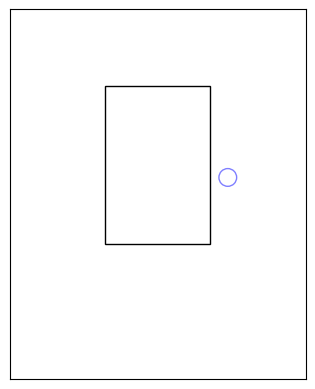

In [ ]:
plot_pitch(px = 0.946181,
           pz = 2.726647,
           sz_top = 3.960415,
           sz_bot = 1.822516)

## 3D Strike Zone

This tool plots an individual pitch like above, but with a 3D box displayed.

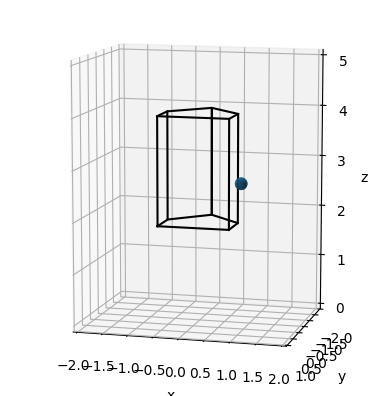

In [ ]:
plot_3d(px = 0.946181,
        pz = 2.726647,
        sz_top = 3.960415,
        sz_bot = 1.822516)

## View all pitches from a particular half-inning

With this tool you can select all called pitches to view within a half-inning in both 2D and 3D, both correct and incorrect calls. It works by marking pitches within the selected half-inning as incorrect so that the script generates the list of pitches and 3D interactive plots for them. The accuracy numbers are then no longer appropriate.

All you have to is change the `game_pk` to be the 6-digit MLB Gameday ID for the game, then select an inning with `override_inning` (you just have to type the number, no quotation marks), and the half-inning in `override_half` (write `"top"` or `"bottom"` in quotation marks and in lowercase).

In [ ]:
_, calls = plot_game(game_pk           = 745248,
                     zone              = "override",
                     plot_each_miss_3d = True,
                     override_inning   = 8,
                     override_half     = "bottom")
calls

# Trackman

To view data from Trackman with the script, first upload the `.csv` file associated with the game into Google Colab. You can do this by clicking on the file folder on the left sidebar, and then clicking the document with the upward arrow which reads "Upload to session storage". You may need to give it a moment for the file to fully upload.

Once you have uploaded the file, write the full name of the file below, and then run the script.

In [ ]:
plot_game_trackman("file.csv",
                   zone_3d = True)

# Features and customization

The script is very customizable, with many options that allow you to control what information is calculated and displayed. The full list of options is here, along with default value and a short explanation of what it does:
* `force_update` (True): always query MLB APIs when getting pitch data for a game, even if the game has already been retrieved
* `display` (True): generate an image for the game
* `save` (True): save the generated graphic within Google Colab's file system
* `live` (False): draw the pitch graphic with a transparent background so that it can be used as a live overlay on broadcast software
* `zone` (`2D`): method of calculating if a pitch is in the strike zone (possible values: `2D`, `3D`, `ABS`)
* `plot_each_miss_3d` (False): generate a second interactive graphic plotting each miss in 3D
* `show_correct_calls` (True): illuminate correct calls as outlined circles on the pitch graphic
* `margin_of_error` (False): only show calls outside the 1" margin of error as incorrect on the list of missed calls and pitch graphic
* `normalize_handedness` (True): flip horizontal positions of pitches to left-handed batters so that the left side of the pitch graphic is always to the inside of the batter, and the right side to the outside, otherwise, just use catcher's view
* `print_incorrect` (True): print a list of missed calls on the left side of the graphic
* `weighted_accuracy` (True): calculate and print the weighted accuracy statistic, which factors the distance of each miss in an overall weighted score
* `machine_learning` (False): use the machine learning add-on (must be installed first, see instructions below on how to install it)
* `umpire_runs_created` (False): calculate and print the "umpire runs created" statistic as a measure of umpire effect on the game outcome and team favor
* `consistency_metrics` (False): calculate and display the effective strike zone using the convex hull model around the set of called strikes and the consistency based on that effective zone

If you want to change an option from its default value, you will have to add it to the list of arguments as follows:
```py
plot_game(753432)  # uses only default settings
plot_game(753432, normalize_handedness=False)  # turns off the normalize_handedness option
```

## Machine Learning Add-on

This extra add-on is a new experimental feature to help classify the quality of miss and the overall difficulty of a game for an umpire to call. There is an artificial neural network trained as a [statistical binary classifier](https://en.wikipedia.org/wiki/Binary_classification). Parameters of the pitch are taken to determine the probability that a particular pitch would be called by the average umpire. Models have been trained for the years 2008 to 2023, so that the probability is relative to umpires that year, while 2024 uses the 2023 model since the sample size is not yet a full season.

The umpire model is used to determine the *Umpire Zone Rating* (uZR) statistic and *expected accuracy* (xACC) metrics. In total, uZR reflects how many calls an umpire did better or worse than average umpires. The xACC is the expected accuracy of an average umpire (using 0-MOE) which can be compared with the actual ACC value.

To explain uZR: If a pitch is called correctly, the uZR is increased by the proportion of umpires that would have called that pitch *incorrectly*. If the pitch is called incorrectly, the uZR is decreased by the probability that the average umpire would call the pitcch *correctly*. For example, if an umpire calls a pitch correct that 90% of other umpires would have also called correctly, 0.1 is added to the uZR, a small number since it is a routine call. If the umpire had called that pitch incorrectly, 0.9 would be subtracted from the uZR, since he is blowing an easy call.

To launch the machine learning add-on, please follow the following steps:
1. [Download the yearly umpire models here.](https://drive.google.com/file/d/1zSUcwFJK8prBwFTz3bVZm27fGlWPaGfv/view?usp=sharing) You do not need to unzip the file or run any programs locally.
2. Upload the model that you downloaded into Google Colab. You can do this by clicking on the file folder on the left sidebar, and then clicking the document with the upward arrow which reads "Upload to session storage". Make sure that the file name exactly matches `umpire_models.zip`. You may need to give it a moment for the file to fully upload.
3. Hit the play button next to the text "3 cells hidden" which will load the neccesary packages and model that you uploaded. Now the machine learning models are available for use.
4. Now that the models are loaded, you can enable them when you run a game report by adding the argument `machine_learning = True` to the functions. When running a game with this setting enabled, there is an additional column in the list of missed calls that has the percent of umpires that would have made that call correctly, and there is also uZR and xACC on the right side.

In [ ]:
!pip install keras==3.3.3
import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
!unzip umpire_models

Archive:  umpire_models.zip
  inflating: model_2010.keras        
  inflating: model_2011.keras        
  inflating: model_2012.keras        
  inflating: model_2013.keras        
  inflating: model_2014.keras        
  inflating: model_2015.keras        
  inflating: model_2016.keras        
  inflating: model_2017.keras        
  inflating: model_2018.keras        
  inflating: model_2019.keras        
  inflating: model_2020.keras        
  inflating: model_2021.keras        
  inflating: model_2022.keras        
  inflating: model_2023.keras        
  inflating: model_2008.keras        
  inflating: model_2009.keras        


In [ ]:
UMPIRE_MODELS = {
    2008: keras.saving.load_model("model_2008.keras"),
    2009: keras.saving.load_model("model_2009.keras"),
    2010: keras.saving.load_model("model_2010.keras"),
    2011: keras.saving.load_model("model_2011.keras"),
    2012: keras.saving.load_model("model_2012.keras"),
    2013: keras.saving.load_model("model_2013.keras"),
    2014: keras.saving.load_model("model_2014.keras"),
    2015: keras.saving.load_model("model_2015.keras"),
    2016: keras.saving.load_model("model_2016.keras"),
    2017: keras.saving.load_model("model_2017.keras"),
    2018: keras.saving.load_model("model_2018.keras"),
    2019: keras.saving.load_model("model_2019.keras"),
    2020: keras.saving.load_model("model_2020.keras"),
    2021: keras.saving.load_model("model_2021.keras"),
    2022: keras.saving.load_model("model_2022.keras"),
    2023: keras.saving.load_model("model_2023.keras"),
    2024: keras.saving.load_model("model_2023.keras"), # same as 2023
}